## OCT Image Classification Project

This project aims to classify OCT (Optical Coherence Tomography) images to detect common retinal diseases, including CNV (Choroidal Neovascularization), DME (Diabetic Macular Edema), DRUSEN, and NORMAL conditions. The dataset used for this project is obtained from [Mendeley Data](https://data.mendeley.com/datasets/rscbjbr9sj/2).


### Dataset Description

The dataset used in this project is obtained from Mendeley Data and contains OCT images of retinas. It consists of a total of X images, categorized into the following classes:
- CNV (Choroidal Neovascularization)
- DME (Diabetic Macular Edema)
- DRUSEN
- NORMAL


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Importing all the libraries needed for the notebook

import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import seaborn as sns
import shutil
import random
from multiprocessing import Pool
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from concurrent.futures import ThreadPoolExecutor
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import AdaBoostClassifier
from collections import defaultdict
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dropout
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from sklearn.metrics import classification_report

In [ ]:
# Set the path to the Colab Notebooks folder in Google Drive
drive_folder_path = '/content/drive/MyDrive/Colab Notebooks'

# Change the current working directory to the Colab Notebooks folder
os.chdir(drive_folder_path)

### Listing all files in the extracted folder

In [ ]:
# Specify the path to the extracted folder
extracted_folder_path = '/content/drive/MyDrive/Colab Notebooks/OCT2017'

# List all files in the extracted folder
file_list = os.listdir(extracted_folder_path)

# Create a DataFrame to store file names
df = pd.DataFrame(file_list, columns=['ImageFileName'])

# Display the first few rows of the DataFrame
print(df.head())


  ImageFileName
0          test
1         train


 ### Getting all the subdirectories

In [ ]:
dataset_path = '/content/drive/MyDrive/Colab Notebooks/OCT2017'

# Check if the main directory exists
if not os.path.exists(dataset_path):
    print(f"Error: Directory '{dataset_path}' does not exist.")
else:
    # Get all subdirectories and their subdirectories (recursively)
    all_subfolders = [root for root, dirs, files in os.walk(dataset_path)]
    print("All subfolders in the main directory (including sub-subfolders):")
    print(all_subfolders)


All subfolders in the main directory (including sub-subfolders):
['/content/drive/MyDrive/Colab Notebooks/OCT2017', '/content/drive/MyDrive/Colab Notebooks/OCT2017/train', '/content/drive/MyDrive/Colab Notebooks/OCT2017/train/CNV', '/content/drive/MyDrive/Colab Notebooks/OCT2017/train/DRUSEN', '/content/drive/MyDrive/Colab Notebooks/OCT2017/train/NORMAL', '/content/drive/MyDrive/Colab Notebooks/OCT2017/train/DME']


### Checking the class distribution

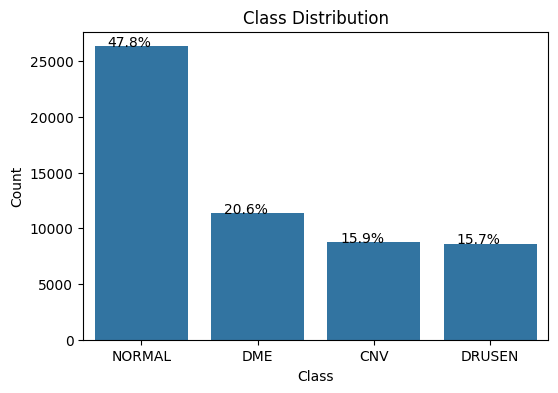

DataFrame Preview:
                                       ImageFileName Class
0  /content/drive/MyDrive/Colab Notebooks/OCT2017...   CNV
1  /content/drive/MyDrive/Colab Notebooks/OCT2017...   CNV
2  /content/drive/MyDrive/Colab Notebooks/OCT2017...   CNV
3  /content/drive/MyDrive/Colab Notebooks/OCT2017...   CNV
4  /content/drive/MyDrive/Colab Notebooks/OCT2017...   CNV


In [ ]:
# Set the path to the dataset
dataset_path = '/content/drive/MyDrive/Colab Notebooks/OCT2017'

# Check if the main directory exists
if not os.path.exists(dataset_path):
    print(f"Error: Directory '{dataset_path}' does not exist.")
else:
    # Initialize an empty list to store file paths
    all_files = []

    # Iterate over all subdirectories (including sub-subdirectories)
    for root, dirs, files in os.walk(dataset_path):
        for file in files:
            # Check if the file is an image (you can add more image extensions)
            if file.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):
                file_path = os.path.join(root, file)
                all_files.append(file_path)

    # Create a DataFrame to store file names
    df = pd.DataFrame(all_files, columns=['ImageFileName'])

    # Extract class labels from the 'ImageFileName' column
    df['Class'] = df['ImageFileName'].apply(lambda x: x.split(os.path.sep)[-2])

    # Plot the class distribution with percentages
    plt.figure(figsize=(6, 4))
    ax = sns.countplot(data=df, x='Class', order=df['Class'].value_counts().index)

    # Add percentages on top of each bar
    total = len(df)
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height() / total)
        x = p.get_x() + p.get_width() / 2 - 0.1
        y = p.get_height() + 20
        ax.text(x, y, percentage, ha="center", fontsize=10)

    plt.title('Class Distribution')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.show()

    # Display the first few rows of the DataFrame
    print("DataFrame Preview:")
    print(df.head())


### Let's print the sample images from the dataset

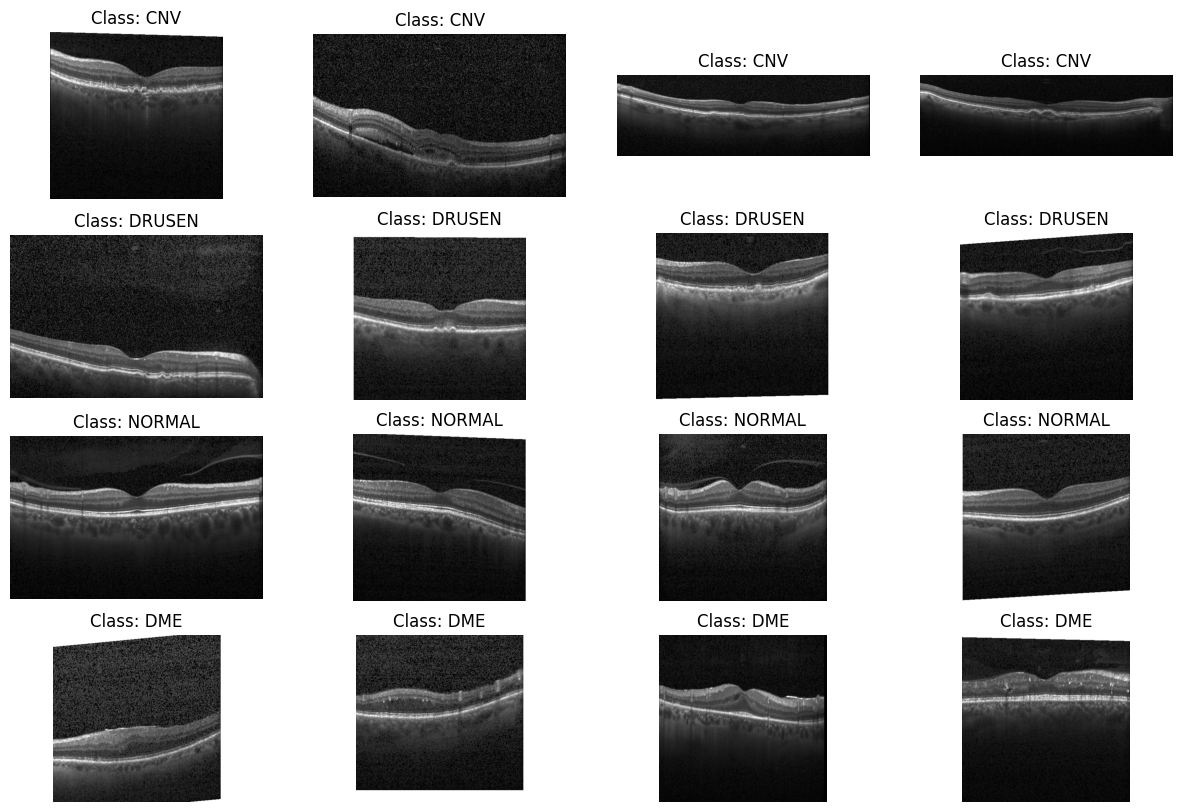

In [ ]:
# Select only the 'train' dataset
train_df = df[df['Dataset'] == 'train']

# Sample four images from each class
sample_images = []
for class_label in train_df['Class'].unique():
    class_images = train_df[train_df['Class'] == class_label]['ImageFileName'].sample(4).tolist()
    sample_images.extend(class_images)

# Plot the sampled images without colormap
plt.figure(figsize=(15, 10))
for i, image_path in enumerate(sample_images, 1):
    plt.subplot(4, 4, i)
    img = mpimg.imread(os.path.join(dataset_path, image_path))
    plt.imshow(img, cmap='gray')  # Set the colormap to 'gray'
    plt.title(f'Class: {df.loc[df["ImageFileName"] == image_path, "Class"].values[0]}')
    plt.axis('off')

plt.show()


### Height and Width distribution

In [ ]:
# Function to get the size of an image
def get_image_size(image_path):
    img = cv2.imread(image_path)
    if img is not None:
        height, width, _ = img.shape
        return height, width
    else:
        return None

# Set the path to the dataset
train_dataset_path = '/content/drive/MyDrive/Colab Notebooks/OCT2017/train'

# Check if the train directory exists
if not os.path.exists(train_dataset_path):
    print(f"Error: Directory '{train_dataset_path}' does not exist.")
else:
    # Initialize lists to store image sizes for each class
    class_labels = []
    class_heights = {}
    class_widths = {}

    # Iterate over subdirectories (each representing a class) within the train directory
    for class_folder in os.listdir(train_dataset_path):
        class_folder_path = os.path.join(train_dataset_path, class_folder)
        if os.path.isdir(class_folder_path):
            # Add the class label to the list
            class_labels.append(class_folder)

            # Initialize lists to store heights and widths for the current class
            heights = []
            widths = []

            # Iterate over files in the current class directory
            for file in os.listdir(class_folder_path):
                # Get the full path of the image file
                image_path = os.path.join(class_folder_path, file)

                # Get the size of the image
                size = get_image_size(image_path)
                if size:
                    height, width = size
                    heights.append(height)
                    widths.append(width)

            # Store the heights and widths for the current class
            class_heights[class_folder] = heights
            class_widths[class_folder] = widths

    # Plot separate histograms for height and width distributions of each class
    for class_label in class_labels:
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        sns.histplot(class_heights[class_label], bins=20, kde=True, color='blue')
        plt.title(f'Height Distribution - {class_label}')
        plt.xlabel('Height')
        plt.ylabel('Frequency')

        plt.subplot(1, 2, 2)
        sns.histplot(class_widths[class_label], bins=20, kde=True, color='green')
        plt.title(f'Width Distribution - {class_label}')
        plt.xlabel('Width')
        plt.ylabel('Frequency')

        plt.tight_layout()
        plt.show()


### Plotting the pixel intensity

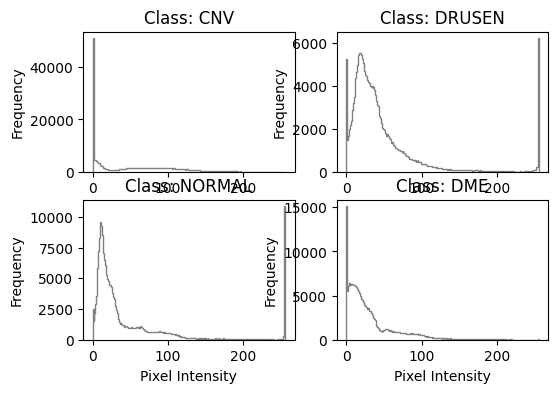

In [ ]:
# Select only the 'train' dataset
train_df = df[df['Dataset'] == 'train']

# Sample one image per class
sample_images = []
for class_label in train_df['Class'].unique():
    class_image = train_df[train_df['Class'] == class_label]['ImageFileName'].sample(1).iloc[0]
    sample_images.append(class_image)

# Plot the grayscale pixel intensity histogram
plt.figure(figsize=(6, 4))

for i, image_path in enumerate(sample_images, 1):
    plt.subplot(2, 2, i)
    img = Image.open(os.path.join(dataset_path, image_path)).convert('L')  # Convert to grayscale
    plt.hist(np.array(img).ravel(), bins=256, color='gray', histtype='step')
    plt.title(f'Class: {df.loc[df["ImageFileName"] == image_path, "Class"].values[0]}')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')

plt.show()


### 20k dataset

#### We are unable to run the models on whole dataset. So we will be trying the models on a datset of 20K images.

In [ ]:
# Function to copy files for a given class
def copy_files(class_info):
    class_name, selected_files, output_path = class_info
    class_output_path = os.path.join(output_path, class_name)
    os.makedirs(class_output_path, exist_ok=True)
    for file_name in selected_files:
        file_path = os.path.join(train_path, class_name, file_name)
        shutil.copy(file_path, class_output_path)
    print(f"Completed copying files for class: {class_name}")

# Define paths
dataset_path = '/content/drive/MyDrive/Colab Notebooks/OCT2017'
train_path = os.path.join(dataset_path, 'train')
output_path = '/content/drive/MyDrive/Colab Notebooks/OCTDATASET20k'

# Create output directory if not exists
if not os.path.exists(output_path):
    os.makedirs(output_path)

# Define total samples to be selected
total_samples = 20000

# Define desired percentages for each class
class_percentages = {
    'CNV': 0.243,
    'DME': 0.185,
    'DRUSEN': 0.141,
    'NORMAL': 0.431
}

# Calculate the number of samples to select for each class based on the percentages
selected_samples = {class_name: int(total_samples * percentage) for class_name, percentage in class_percentages.items()}

# Define class-wise sample counts and store filenames
class_files = {}
for class_name in class_percentages.keys():
    class_path = os.path.join(train_path, class_name)
    class_files[class_name] = os.listdir(class_path)

# Prepare data for multiprocessing
class_info_list = [(class_name, random.sample(class_files[class_name], count), output_path) for class_name, count in selected_samples.items()]

# Copy files for each class in parallel
with Pool() as pool:
    pool.map(copy_files, class_info_list)

print("Dataset with 20,000 samples created successfully.")


Completed copying files for class: DRUSEN
Completed copying files for class: DME
Completed copying files for class: CNV


### Kernel got disconnected after creating 3 classes. Thus creating samples for "Normal" class separately.

In [ ]:
# Function to copy files for the 'NORMAL' class
def copy_normal_files(selected_files):
    class_name = 'NORMAL'
    class_output_path = os.path.join(output_path, class_name)
    os.makedirs(class_output_path, exist_ok=True)
    for file_name in selected_files:
        file_path = os.path.join(train_path, class_name, file_name)
        shutil.copy(file_path, class_output_path)

# Define paths
dataset_path = '/content/drive/MyDrive/Colab Notebooks/OCT2017'
train_path = os.path.join(dataset_path, 'train')
output_path = '/content/drive/MyDrive/Colab Notebooks/OCTDATASET20k'

# Define total samples to be selected
total_samples = 8620

# Get the list of files in the 'NORMAL' class
normal_files = os.listdir(os.path.join(train_path, 'NORMAL'))

# Randomly select the required number of records for the 'NORMAL' class
selected_normal_files = random.sample(normal_files, total_samples)

# Copy files for the 'NORMAL' class in parallel
with Pool() as pool:
    pool.map(copy_normal_files, [selected_normal_files])

print(f"Dataset with {total_samples} samples for the 'NORMAL' class created successfully.")


Dataset with 8620 samples for the 'NORMAL' class created successfully.


### Verifying the distribution of classes within the 20k image dataset to ensure that the percentage of samples for each class remains consistent with the overall population

In [ ]:
import os

# Define path to the dataset
dataset_path = '/content/drive/MyDrive/Colab Notebooks/OCTDATASET20k'

# Initialize a dictionary to store the counts
class_counts = {}

# Count total number of images in the dataset
total_images = sum(len(files) for _, _, files in os.walk(dataset_path))

# Iterate through each class folder
for class_name in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_name)
    # Count the number of images in the class folder
    num_images = len(os.listdir(class_path))
    class_counts[class_name] = num_images

# Calculate and print the counts and percentages for each class
for class_name, count in class_counts.items():
    percentage = (count / total_images) * 100
    print(f"{class_name}: {count} images ({percentage:.2f}%)")


CNV: 4860 images (24.30%)
DME: 3700 images (18.50%)
DRUSEN: 2819 images (14.10%)
NORMAL: 8620 images (43.10%)


### Gathering pixel value range, mean, and standard deviation, alongside image size and resolution details for 20k images.

In [ ]:
# Function to calculate metrics for a class
def calculate_metrics_for_class(class_path):
    num_images = 0
    mean_pixel_value = 0
    std_pixel_value = 0
    min_pixel_value = float('inf')
    max_pixel_value = float('-inf')
    total_height = 0
    total_width = 0

    # Iterate through each image file in the class folder
    for filename in os.listdir(class_path):
        # Load the image
        image_path = os.path.join(class_path, filename)
        image = cv2.imread(image_path)

        # Check if the image is loaded successfully
        if image is None:
            print(f"Warning: Failed to load image '{image_path}'")
            continue

        # Increment number of images
        num_images += 1

        # Update pixel value statistics
        pixel_values = image.flatten()
        mean_pixel_value += np.mean(pixel_values)
        std_pixel_value += np.std(pixel_values)
        min_pixel_value = min(min_pixel_value, np.min(pixel_values))
        max_pixel_value = max(max_pixel_value, np.max(pixel_values))

        # Update image size statistics
        total_height += image.shape[0]
        total_width += image.shape[1]

    # Calculate average metrics
    if num_images > 0:
        mean_pixel_value /= num_images
        std_pixel_value /= num_images
        avg_height = total_height / num_images
        avg_width = total_width / num_images
    else:
        mean_pixel_value = std_pixel_value = avg_height = avg_width = 0

    return {
        'Number of Images': num_images,
        'Mean Pixel Value': mean_pixel_value,
        'Std Deviation Pixel Value': std_pixel_value,
        'Min Pixel Value': min_pixel_value if num_images > 0 else 0,
        'Max Pixel Value': max_pixel_value if num_images > 0 else 0,
        'Average Height': avg_height,
        'Average Width': avg_width
    }

# Define path to the dataset
dataset_path = '/content/drive/MyDrive/Colab Notebooks/OCTDATASET20k'

# Initialize dictionary to store metrics for each class
class_metrics = {}

# Iterate through each class folder
for class_name in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_name)
    # Calculate metrics for the class
    class_metrics[class_name] = calculate_metrics_for_class(class_path)

# Print the results for each class
for class_name, metrics in class_metrics.items():
    print(f"\nMetrics for class {class_name}:")
    for metric, value in metrics.items():
        print(f"{metric}: {value}")



Metrics for class CNV:
Number of Images: 4860
Mean Pixel Value: 51.72695888524499
Std Deviation Pixel Value: 52.37628909175543
Min Pixel Value: 0
Max Pixel Value: 255
Average Height: 496.0
Average Width: 732.3654320987654

Metrics for class DME:
Number of Images: 3711
Mean Pixel Value: 50.776676179923776
Std Deviation Pixel Value: 52.2160609397992
Min Pixel Value: 0
Max Pixel Value: 255
Average Height: 508.20156292104554
Average Width: 564.7038534087847

Metrics for class DRUSEN:
Number of Images: 1763
Mean Pixel Value: 48.995492261543745
Std Deviation Pixel Value: 51.707181787653376
Min Pixel Value: 0
Max Pixel Value: 255
Average Height: 496.0
Average Width: 660.5467952353943

Metrics for class NORMAL:
Number of Images: 105
Mean Pixel Value: 44.65186065619136
Std Deviation Pixel Value: 49.65765712802466
Min Pixel Value: 0
Max Pixel Value: 255
Average Height: 500.1142857142857
Average Width: 699.7333333333333


### Resize and normalize images: Resizes to 256x256 pixels and normalizes pixel values to [0, 1] by dividing by 255.

In [ ]:
# Function to resize and normalize images
def preprocess_image(image, target_size=(256, 256)):
    # Resize image to target size
    resized_image = cv2.resize(image, target_size)
    # Normalize pixel values to range [0, 1]
    normalized_image = resized_image.astype(np.float32) / 255.0
    return normalized_image

# Define path to the dataset and save directory
dataset_path = '/content/drive/MyDrive/Colab Notebooks/OCTDATASET20k'
save_path = '/content/drive/MyDrive/Colab Notebooks/OCTDATASET20k_normalized'

# Create save directory if it doesn't exist
os.makedirs(save_path, exist_ok=True)

# Function to process and save images
def process_image(image_path):
    # Load the image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Failed to load image: {image_path}")
        return
    # Preprocess the image (resize and normalize)
    processed_image = preprocess_image(image)
    # Save the normalized image
    save_image_path = os.path.join(save_path, os.path.basename(os.path.dirname(image_path)), os.path.basename(image_path))
    os.makedirs(os.path.dirname(save_image_path), exist_ok=True)
    cv2.imwrite(save_image_path, (processed_image * 255).astype(np.uint8))

# Function to process images for a class
def process_class(class_name):
    print(f"Processing class: {class_name}")
    class_path = os.path.join(dataset_path, class_name)
    class_image_paths = [os.path.join(class_path, filename) for filename in os.listdir(class_path)]
    with ThreadPoolExecutor() as executor:
        executor.map(process_image, class_image_paths)
    print(f"Class {class_name} processing completed.")

# Process images for each class
for class_name in os.listdir(dataset_path):
    process_class(class_name)


Processing class: CNV
Class CNV processing completed.
Processing class: DME
Class DME processing completed.
Processing class: DRUSEN
Class DRUSEN processing completed.
Processing class: NORMAL
Class NORMAL processing completed.


### Validating the number of images after normalization.

In [ ]:
# Define path to the dataset
dataset_path = '/content/drive/MyDrive/Colab Notebooks/OCTDATASET20k_normalized'

# Initialize a dictionary to store the counts
class_counts = {}

# Iterate through each class folder
for class_name in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_name)
    # Count the number of images in the class folder
    num_images = len(os.listdir(class_path))
    class_counts[class_name] = num_images

# Print the counts for each class
for class_name, count in class_counts.items():
    print(f"{class_name}: {count} images")


CNV: 3108 images
DME: 3700 images
DRUSEN: 2819 images
NORMAL: 8620 images


#### Correcting CNV images after normalization. Due to computational issues, focusing on CNV images for now instead of processing the entire dataset.

In [ ]:
# Function to resize and normalize images
def preprocess_image(image, target_size=(256, 256)):
    # Resize image to target size
    resized_image = cv2.resize(image, target_size)
    # Normalize pixel values to range [0, 1]
    normalized_image = resized_image.astype(np.float32) / 255.0
    return normalized_image

# Define path to the dataset and save directory
dataset_path = '/content/drive/MyDrive/Colab Notebooks/OCTDATASET20k'
save_path = '/content/drive/MyDrive/Colab Notebooks/OCTDATASET20k_normalized'

# Create save directory if it doesn't exist
os.makedirs(save_path, exist_ok=True)

# Function to process and save CNV images
def process_cnv_image(image_path):
    # Load the image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Failed to load image: {image_path}")
        return
    # Preprocess the image (resize and normalize)
    processed_image = preprocess_image(image)
    # Save the normalized image
    save_image_path = os.path.join(save_path, os.path.basename(os.path.dirname(image_path)), os.path.basename(image_path))
    os.makedirs(os.path.dirname(save_image_path), exist_ok=True)
    cv2.imwrite(save_image_path, (processed_image * 255).astype(np.uint8))

# Process CNV images
cnv_path = os.path.join(dataset_path, 'CNV')
cnv_image_paths = [os.path.join(cnv_path, filename) for filename in os.listdir(cnv_path)]
with ThreadPoolExecutor() as executor:
    executor.map(process_cnv_image, cnv_image_paths)

print("CNV images normalized successfully.")

# Identify missing CNV images
original_cnv_images = set(os.listdir(os.path.join(dataset_path, 'CNV')))
normalized_cnv_images = set(os.listdir(os.path.join(save_path, 'CNV')))
missing_cnv_images = original_cnv_images - normalized_cnv_images

print(f"Missing CNV images after normalization: {missing_cnv_images}")


CNV images normalized successfully.
Missing CNV images after normalization: set()


#### Validating the distribution of 20k images once again

In [ ]:
# Define path to the dataset
dataset_path = '/content/drive/MyDrive/Colab Notebooks/OCTDATASET20k_normalized'

# Initialize a dictionary to store the counts
class_counts = {}

# Iterate through each class folder
for class_name in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_name)
    # Count the number of images in the class folder
    num_images = len(os.listdir(class_path))
    class_counts[class_name] = num_images

# Print the counts for each class
for class_name, count in class_counts.items():
    print(f"{class_name}: {count} images")


CNV: 4860 images
DME: 3700 images
DRUSEN: 2819 images
NORMAL: 8620 images


# MODELLING PHASE

## 1. Random Forest classifier

####The model performs better on the training dataset compared to the testing dataset, indicated by higher accuracy, precision, recall, and F1-score values for the training set. This suggests potential overfitting, where the model may have learned to perform well on the training data but struggles to generalize to unseen data.text*

In [ ]:
# Define paths
dataset_path = '/content/drive/MyDrive/Colab Notebooks/OCTDATASET20k_normalized'

# Load images and labels
X = []
y = []

for class_name in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_name)
    for filename in os.listdir(class_path):
        image_path = os.path.join(class_path, filename)
        image = cv2.imread(image_path)
        if image is not None:
            X.append(image.flatten())  # Flatten the image as feature
            y.append(class_name)

# Convert to numpy arrays
X = np.array(X)
y = np.array(y)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=200, max_depth=10, max_features='sqrt', random_state=42)
rf_classifier.fit(X_train, y_train)

# Predictions on train and test sets
y_train_pred = rf_classifier.predict(X_train)
y_test_pred = rf_classifier.predict(X_test)

# Compute evaluation metrics
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
train_precision = precision_score(y_train, y_train_pred, average='weighted')
test_precision = precision_score(y_test, y_test_pred, average='weighted')
train_recall = recall_score(y_train, y_train_pred, average='weighted')
test_recall = recall_score(y_test, y_test_pred, average='weighted')
train_f1 = f1_score(y_train, y_train_pred, average='weighted')
test_f1 = f1_score(y_test, y_test_pred, average='weighted')

# Confusion matrix
train_conf_matrix = confusion_matrix(y_train, y_train_pred)
test_conf_matrix = confusion_matrix(y_test, y_test_pred)

# Print evaluation metrics
print("Train Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)
print("Train Precision:", train_precision)
print("Test Precision:", test_precision)
print("Train Recall:", train_recall)
print("Test Recall:", test_recall)
print("Train F1-score:", train_f1)
print("Test F1-score:", test_f1)
print("\nTrain Confusion Matrix:\n", train_conf_matrix)
print("\nTest Confusion Matrix:\n", test_conf_matrix)


Train Accuracy: 0.7655682674522162
Test Accuracy: 0.5794520547945206
Train Precision: 0.8427901126668152
Test Precision: 0.6612902812222957
Train Recall: 0.7655682674522162
Test Recall: 0.5794520547945206
Train F1-score: 0.7440118708689517
Test F1-score: 0.5008363280543155

Train Confusion Matrix:
 [[1791    0    0  705]
 [   0 1893    0 1069]
 [   3    1  594 1643]
 [   0    0    1 6897]]

Test Confusion Matrix:
 [[ 196   51    1  364]
 [  29  248    0  461]
 [  17   10    5  546]
 [  27   29    0 1666]]


In [ ]:
# Display metrics for the test set
print("Test Metrics:")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")
print(f"Test F1-score: {test_f1}")

# Display metrics for the train set
print("\nTrain Metrics:")
print(f"Train Accuracy: {train_accuracy}")
print(f"Train Precision: {train_precision}")
print(f"Train Recall: {train_recall}")
print(f"Train F1-score: {train_f1}")


Test Metrics:
Test Accuracy: 0.5794520547945206
Test Precision: 0.6612902812222957
Test Recall: 0.5794520547945206
Test F1-score: 0.5008363280543155

Train Metrics:
Train Accuracy: 0.7655682674522162
Train Precision: 0.8427901126668152
Train Recall: 0.7655682674522162
Train F1-score: 0.7440118708689517


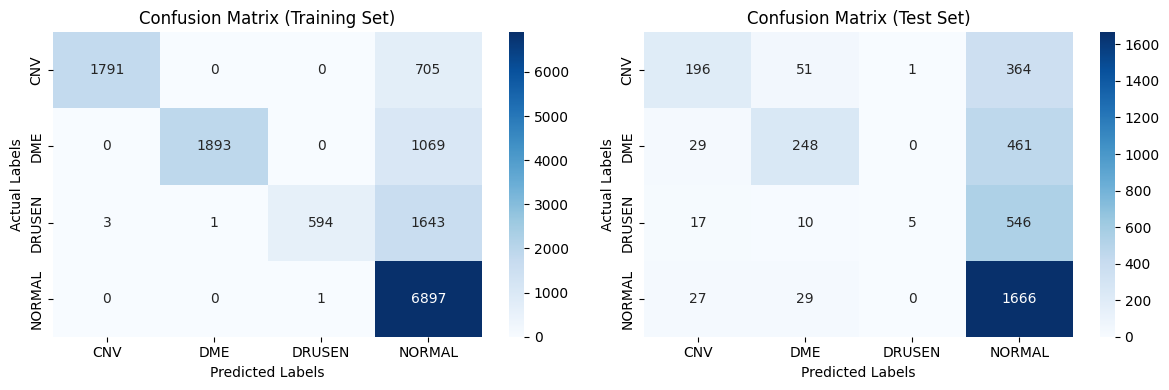

In [ ]:
# Compute confusion matrix for the training set
train_conf_matrix = confusion_matrix(y_train, y_train_pred, labels=np.unique(y))

# Compute confusion matrix for the test set
test_conf_matrix = confusion_matrix(y_test, y_test_pred, labels=np.unique(y))

# Plot confusion matrices side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Plot confusion matrix for the training set
sns.heatmap(train_conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y), ax=axes[0])
axes[0].set_title('Confusion Matrix (Training Set)')
axes[0].set_xlabel('Predicted Labels')
axes[0].set_ylabel('Actual Labels')

# Plot confusion matrix for the test set
sns.heatmap(test_conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y), ax=axes[1])
axes[1].set_title('Confusion Matrix (Test Set)')
axes[1].set_xlabel('Predicted Labels')
axes[1].set_ylabel('Actual Labels')

plt.tight_layout()
plt.show()


## 2. K-Nearest Neighbors (KNN) Classifier

####The KNN model shows mediocre performance on both training and testing sets, with an accuracy of approximately 55% on the training set and only 33.5% on the testing set. The confusion matrices and classification reports reveal that the model struggles to effectively classify all classes, particularly evident in the low precision, recall, and F1-scores across classes in both sets. This indicates that the model's ability to generalize to unseen data is limited, suggesting a need for further model refinement or exploration of alternative algorithms.

In [ ]:
# Define dataset path
dataset_path = '/content/drive/MyDrive/Colab Notebooks/OCTDATASET20k_normalized'

# Define the number of images to load per class
num_images_per_class = 1000

# Load data and labels
data = []
labels = []

# Load images per class
def load_images_from_class(class_path, num_images_to_load):
    images_count = 0
    for file_name in os.listdir(class_path):
        if images_count >= num_images_to_load:
            break
        image_path = os.path.join(class_path, file_name)
        try:
            # Load image using OpenCV
            image_data = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            if image_data is not None:
                data.append(image_data)
                labels.append(os.path.basename(class_path))
                images_count += 1
            else:
                print(f"Error: Unable to load image {image_path}")
        except Exception as e:
            print(f"Error loading image {image_path}: {e}")

# Load 1000 images per class
for class_name in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_name)
    if class_name == 'CNV':
        load_images_from_class(class_path, num_images_per_class)
    elif class_name == 'DME':
        load_images_from_class(class_path, num_images_per_class)
    elif class_name == 'DRUSEN':
        load_images_from_class(class_path, num_images_per_class)
    elif class_name == 'NORMAL':
        load_images_from_class(class_path, num_images_per_class)

# Convert lists to numpy arrays
data = np.array(data)
labels = np.array(labels)

# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# Define and train KNN classifier with 7 neighbors and Manhattan distance (p=1)
knn_classifier = KNeighborsClassifier(n_neighbors=7, p=1)
knn_classifier.fit(X_train.reshape(X_train.shape[0], -1), y_train)

# Predict on the training and test sets
y_train_pred_knn = knn_classifier.predict(X_train.reshape(X_train.shape[0], -1))
y_test_pred_knn = knn_classifier.predict(X_test.reshape(X_test.shape[0], -1))

# Calculate accuracy for training and testing sets
train_accuracy_knn = accuracy_score(y_train, y_train_pred_knn)
test_accuracy_knn = accuracy_score(y_test, y_test_pred_knn)

print("Training Accuracy (KNN):", train_accuracy_knn)
print("Testing Accuracy (KNN):", test_accuracy_knn)

# Compute confusion matrix for training and testing sets
train_conf_matrix_knn = confusion_matrix(y_train, y_train_pred_knn)
test_conf_matrix_knn = confusion_matrix(y_test, y_test_pred_knn)

print("\nConfusion Matrix (Training Set - KNN):\n", train_conf_matrix_knn)
print("\nConfusion Matrix (Testing Set - KNN):\n", test_conf_matrix_knn)

# Calculate precision, recall, and F1-score for training and testing sets
train_precision_knn = precision_score(y_train, y_train_pred_knn, average='macro')
test_precision_knn = precision_score(y_test, y_test_pred_knn, average='macro')

train_recall_knn = recall_score(y_train, y_train_pred_knn, average='macro')
test_recall_knn = recall_score(y_test, y_test_pred_knn, average='macro')

train_f1_knn = f1_score(y_train, y_train_pred_knn, average='macro')
test_f1_knn = f1_score(y_test, y_test_pred_knn, average='macro')

print("\nPrecision (Training Set - KNN):", train_precision_knn)
print("Precision (Testing Set - KNN):", test_precision_knn)

print("\nRecall (Training Set - KNN):", train_recall_knn)
print("Recall (Testing Set - KNN):", test_recall_knn)

print("\nF1-score (Training Set - KNN):", train_f1_knn)
print("F1-score (Testing Set - KNN):", test_f1_knn)

# Additional metrics (precision, recall, F1-score) for training set
print("\nClassification Report (Training Set - KNN):\n", classification_report(y_train, y_train_pred_knn))

# Additional metrics (precision, recall, F1-score) for testing set
print("\nClassification Report (Testing Set - KNN):\n", classification_report(y_test, y_test_pred_knn))


Training Accuracy (KNN): 0.5490625
Testing Accuracy (KNN): 0.335

Confusion Matrix (Training Set - KNN):
 [[384 193 124  90]
 [ 72 498 102 115]
 [ 93 152 431 130]
 [ 57 165 150 444]]

Confusion Matrix (Testing Set - KNN):
 [[44 69 52 44]
 [42 90 34 47]
 [30 35 69 60]
 [25 44 50 65]]

Precision (Training Set - KNN): 0.5579373255574883
Precision (Testing Set - KNN): 0.33192982246810965

Recall (Training Set - KNN): 0.5492753153883888
Recall (Testing Set - KNN): 0.33549812492877007

F1-score (Training Set - KNN): 0.5489429655954923
F1-score (Testing Set - KNN): 0.3303515787806545

Classification Report (Training Set - KNN):
               precision    recall  f1-score   support

         CNV       0.63      0.49      0.55       791
         DME       0.49      0.63      0.55       787
      DRUSEN       0.53      0.53      0.53       806
      NORMAL       0.57      0.54      0.56       816

    accuracy                           0.55      3200
   macro avg       0.56      0.55      0.55 

## 3. Support Vector Machines (SVM) Classifier

####The SVM model exhibits perfect training accuracy, suggesting it has memorized the training data, yet it severely underperforms on the testing set with an accuracy of only 23.4%. The confusion matrices and classification reports highlight significant misclassifications, especially for classes CNV, DME, and DRUSEN, with low precision, recall, and F1-scores. Interestingly, the model fails to predict any instances for CNV and DME classes in the testing set, resulting in precision and recall values of 0 for these classes.

In [ ]:
# Define and train SVM classifier with C=1, gamma='auto', and kernel='rbf'
svm_classifier = SVC(C=1, gamma='auto', kernel='rbf')
svm_classifier.fit(X_train.reshape(X_train.shape[0], -1), y_train)

# Predict on the training and test sets
y_train_pred_svm = svm_classifier.predict(X_train.reshape(X_train.shape[0], -1))
y_test_pred_svm = svm_classifier.predict(X_test.reshape(X_test.shape[0], -1))

# Calculate accuracy for training and testing sets
train_accuracy_svm = accuracy_score(y_train, y_train_pred_svm)
test_accuracy_svm = accuracy_score(y_test, y_test_pred_svm)

print("Training Accuracy (SVM):", train_accuracy_svm)
print("Testing Accuracy (SVM):", test_accuracy_svm)

# Compute confusion matrix for training and testing sets
train_conf_matrix_svm = confusion_matrix(y_train, y_train_pred_svm)
test_conf_matrix_svm = confusion_matrix(y_test, y_test_pred_svm)

print("\nConfusion Matrix (Training Set - SVM):\n", train_conf_matrix_svm)
print("\nConfusion Matrix (Testing Set - SVM):\n", test_conf_matrix_svm)

# Calculate precision, recall, and F1-score for training and testing sets
train_precision_svm = precision_score(y_train, y_train_pred_svm, average='macro')
test_precision_svm = precision_score(y_test, y_test_pred_svm, average='macro')

train_recall_svm = recall_score(y_train, y_train_pred_svm, average='macro')
test_recall_svm = recall_score(y_test, y_test_pred_svm, average='macro')

train_f1_svm = f1_score(y_train, y_train_pred_svm, average='macro')
test_f1_svm = f1_score(y_test, y_test_pred_svm, average='macro')

print("\nPrecision (Training Set - SVM):", train_precision_svm)
print("Precision (Testing Set - SVM):", test_precision_svm)

print("\nRecall (Training Set - SVM):", train_recall_svm)
print("Recall (Testing Set - SVM):", test_recall_svm)

print("\nF1-score (Training Set - SVM):", train_f1_svm)
print("F1-score (Testing Set - SVM):", test_f1_svm)

# Additional metrics (precision, recall, F1-score) for training set
print("\nClassification Report (Training Set - SVM):\n", classification_report(y_train, y_train_pred_svm))

# Additional metrics (precision, recall, F1-score) for testing set
print("\nClassification Report (Testing Set - SVM):\n", classification_report(y_test, y_test_pred_svm))


Training Accuracy (SVM): 1.0
Testing Accuracy (SVM): 0.23375

Confusion Matrix (Training Set - SVM):
 [[791   0   0   0]
 [  0 787   0   0]
 [  0   0 806   0]
 [  0   0   0 816]]

Confusion Matrix (Testing Set - SVM):
 [[  0   0   1 208]
 [  0   0   0 213]
 [  0   0   3 191]
 [  0   0   0 184]]

Precision (Training Set - SVM): 1.0
Precision (Testing Set - SVM): 0.2452889447236181

Recall (Training Set - SVM): 1.0
Recall (Testing Set - SVM): 0.2538659793814433

F1-score (Training Set - SVM): 1.0
F1-score (Testing Set - SVM): 0.10145330859616576

Classification Report (Training Set - SVM):
               precision    recall  f1-score   support

         CNV       1.00      1.00      1.00       791
         DME       1.00      1.00      1.00       787
      DRUSEN       1.00      1.00      1.00       806
      NORMAL       1.00      1.00      1.00       816

    accuracy                           1.00      3200
   macro avg       1.00      1.00      1.00      3200
weighted avg       1.00 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:13

## 4.1 AdaBoost with 50 estimators and learning rate of 0.1

####The provided results depict a classifier with poor performance on both the training and testing sets. Despite achieving a moderate precision for the training set, the model struggles with recall and F1-score metrics, especially for classes DME and DRUSEN. Additionally, the precision and recall for the testing set are considerably low, indicating the model's inability to effectively generalize to unseen data. The confusion matrices reveal significant misclassifications across all classes, further emphasizing the model's limitations. Overall, these results suggest the need for significant improvements in feature selection, model tuning, or possibly exploring alternative algorithms to enhance classification performance.

In [ ]:
# Define dataset path
dataset_path = '/content/drive/MyDrive/Colab Notebooks/OCTDATASET20k_normalized'

# Define the number of images to load per class
num_images_cnv = 1215
num_images_dme = 925
num_images_drusen = 706
num_images_normal = 2155

# Load data and labels
data = []
labels = []

# Load images per class
def load_images_from_class(class_path, num_images_to_load):
    images_count = 0
    for file_name in os.listdir(class_path):
        if images_count >= num_images_to_load:
            break
        image_path = os.path.join(class_path, file_name)
        try:
            # Load image using OpenCV
            image_data = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            if image_data is not None:
                data.append(image_data)
                labels.append(os.path.basename(class_path))
                images_count += 1
            else:
                print(f"Error: Unable to load image {image_path}")
        except Exception as e:
            print(f"Error loading image {image_path}: {e}")

# Load 25% of images per class
for class_name in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_name)
    if class_name == 'CNV':
        load_images_from_class(class_path, num_images_cnv)
    elif class_name == 'DME':
        load_images_from_class(class_path, num_images_dme)
    elif class_name == 'DRUSEN':
        load_images_from_class(class_path, num_images_drusen)
    elif class_name == 'NORMAL':
        load_images_from_class(class_path, num_images_normal)

# Convert lists to numpy arrays
data = np.array(data)
labels = np.array(labels)

# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# Define and train AdaBoost classifier with the best parameters
ada_classifier = AdaBoostClassifier(n_estimators=50, learning_rate=0.1)
ada_classifier.fit(X_train.reshape(X_train.shape[0], -1), y_train)

# Predict on the training and test sets
y_train_pred = ada_classifier.predict(X_train.reshape(X_train.shape[0], -1))
y_test_pred = ada_classifier.predict(X_test.reshape(X_test.shape[0], -1))

# Calculate accuracy for training and testing sets
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print("Training Accuracy:", train_accuracy)
print("Testing Accuracy:", test_accuracy)

# Compute confusion matrix for training and testing sets
train_conf_matrix = confusion_matrix(y_train, y_train_pred)
test_conf_matrix = confusion_matrix(y_test, y_test_pred)

print("\nConfusion Matrix (Training Set):\n", train_conf_matrix)
print("\nConfusion Matrix (Testing Set):\n", test_conf_matrix)

# Calculate precision, recall, and F1-score for training and testing sets
train_precision = precision_score(y_train, y_train_pred, average='macro')
test_precision = precision_score(y_test, y_test_pred, average='macro')

train_recall = recall_score(y_train, y_train_pred, average='macro')
test_recall = recall_score(y_test, y_test_pred, average='macro')

train_f1 = f1_score(y_train, y_train_pred, average='macro')
test_f1 = f1_score(y_test, y_test_pred, average='macro')

print("\nPrecision (Training Set):", train_precision)
print("Precision (Testing Set):", test_precision)

print("\nRecall (Training Set):", train_recall)
print("Recall (Testing Set):", test_recall)

print("\nF1-score (Training Set):", train_f1)
print("F1-score (Testing Set):", test_f1)

# Additional metrics (precision, recall, F1-score) for training set
print("\nClassification Report (Training Set):\n", classification_report(y_train, y_train_pred))

# Additional metrics (precision, recall, F1-score) for testing set
print("\nClassification Report (Testing Set):\n", classification_report(y_test, y_test_pred))


Training Accuracy: 0.47375
Testing Accuracy: 0.47152847152847155

Confusion Matrix (Training Set):
 [[ 209    2    0  738]
 [  60    3    0  694]
 [  16    0    0  553]
 [  42    0    0 1683]]

Confusion Matrix (Testing Set):
 [[ 58   0   0 208]
 [ 17   0   0 151]
 [  7   0   0 130]
 [ 16   0   0 414]]

Precision (Training Set): 0.4244942206170233
Precision (Testing Set): 0.26257712387280496

Recall (Training Set): 0.29996175219340704
Recall (Testing Set): 0.29520895261409336

F1-score (Training Set): 0.2399006573670609
F1-score (Testing Set): 0.23495915187588107

Classification Report (Training Set):
               precision    recall  f1-score   support

         CNV       0.64      0.22      0.33       949
         DME       0.60      0.00      0.01       757
      DRUSEN       0.00      0.00      0.00       569
      NORMAL       0.46      0.98      0.62      1725

    accuracy                           0.47      4000
   macro avg       0.42      0.30      0.24      4000
weighted a

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: Undefined

## 4.2 AdaBoost with 200 estimators and learning rate of 0.1

####The model achieves around 52% accuracy on the training set and 50% on the testing set. While it shows better performance in identifying the NORMAL class, it struggles with lower precision, recall, and F1-scores for classes CNV, DME, and DRUSEN. Further improvements are needed to enhance classification accuracy across all classes.

In [ ]:
# Define the number of images to load per class
num_images_cnv = 1215
num_images_dme = 925
num_images_drusen = 706
num_images_normal = 2155

# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# Define and train AdaBoost classifier with the specified parameters
ada_classifier = AdaBoostClassifier(n_estimators=200, learning_rate=0.1)
ada_classifier.fit(X_train.reshape(X_train.shape[0], -1), y_train)

# Predict on the training and test sets
y_train_pred = ada_classifier.predict(X_train.reshape(X_train.shape[0], -1))
y_test_pred = ada_classifier.predict(X_test.reshape(X_test.shape[0], -1))

# Calculate accuracy for training and testing sets
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print("Training Accuracy:", train_accuracy)
print("Testing Accuracy:", test_accuracy)

# Compute confusion matrix for training and testing sets
train_conf_matrix = confusion_matrix(y_train, y_train_pred)
test_conf_matrix = confusion_matrix(y_test, y_test_pred)

print("\nConfusion Matrix (Training Set):\n", train_conf_matrix)
print("\nConfusion Matrix (Testing Set):\n", test_conf_matrix)

# Calculate precision, recall, and F1-score for training and testing sets
train_precision = precision_score(y_train, y_train_pred, average='macro')
test_precision = precision_score(y_test, y_test_pred, average='macro')

train_recall = recall_score(y_train, y_train_pred, average='macro')
test_recall = recall_score(y_test, y_test_pred, average='macro')

train_f1 = f1_score(y_train, y_train_pred, average='macro')
test_f1 = f1_score(y_test, y_test_pred, average='macro')

print("\nPrecision (Training Set):", train_precision)
print("Precision (Testing Set):", test_precision)

print("\nRecall (Training Set):", train_recall)
print("Recall (Testing Set):", test_recall)

print("\nF1-score (Training Set):", train_f1)
print("F1-score (Testing Set):", test_f1)

# Additional metrics (precision, recall, F1-score) for training set
print("\nClassification Report (Training Set):\n", classification_report(y_train, y_train_pred))

# Additional metrics (precision, recall, F1-score) for testing set
print("\nClassification Report (Testing Set):\n", classification_report(y_test, y_test_pred))


Training Accuracy: 0.51775
Testing Accuracy: 0.5014985014985015

Confusion Matrix (Training Set):
 [[ 379   33    0  537]
 [  89   46    0  622]
 [  48    4    0  517]
 [  67   12    0 1646]]

Confusion Matrix (Testing Set):
 [[ 93   6   0 167]
 [ 26   7   0 135]
 [  9   1   0 127]
 [ 25   3   0 402]]

Precision (Training Set): 0.40744523435290714
Precision (Testing Set): 0.37584058894315847

Recall (Training Set): 0.35358420909535265
Recall (Testing Set): 0.3315436119368188

F1-score (Training Set): 0.31375699075061747
F1-score (Testing Set): 0.2892947429325157

Classification Report (Training Set):
               precision    recall  f1-score   support

         CNV       0.65      0.40      0.49       949
         DME       0.48      0.06      0.11       757
      DRUSEN       0.00      0.00      0.00       569
      NORMAL       0.50      0.95      0.65      1725

    accuracy                           0.52      4000
   macro avg       0.41      0.35      0.31      4000
weighted av

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: Undefined

## 5. GradientBoostingClassifier with 50 estimators and a learning rate of 0.1.

####The Gradient Boosting model with 50 estimators achieves high training accuracy of 91.6% but relatively lower testing accuracy of 46.9%. While it demonstrates strong precision, recall, and F1-scores for all classes on the training set, its performance on the testing set is less consistent. The model performs reasonably well in classifying CNV and DME classes but struggles with lower precision, recall, and F1-scores for DRUSEN and NORMAL classes on the testing set. This suggests a potential issue of overfitting, where the model fits too closely to the training data, resulting in reduced generalization performance on unseen data. Further optimization or regularization techniques may be needed to improve the model's ability to generalize to new data.

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

# Define and train Gradient Boosting classifier with 50 estimators and learning rate 0.1
gb_classifier_50 = GradientBoostingClassifier(n_estimators=50, learning_rate=0.1)
gb_classifier_50.fit(X_train.reshape(X_train.shape[0], -1), y_train)

# Predict on the training and test sets using the Gradient Boosting classifier with 50 estimators
y_train_pred_gb_50 = gb_classifier_50.predict(X_train.reshape(X_train.shape[0], -1))
y_test_pred_gb_50 = gb_classifier_50.predict(X_test.reshape(X_test.shape[0], -1))

# Calculate accuracy for training and testing sets
train_accuracy_gb_50 = accuracy_score(y_train, y_train_pred_gb_50)
test_accuracy_gb_50 = accuracy_score(y_test, y_test_pred_gb_50)

print("Training Accuracy (Gradient Boosting - 50 Estimators):", train_accuracy_gb_50)
print("Testing Accuracy (Gradient Boosting - 50 Estimators):", test_accuracy_gb_50)

# Compute confusion matrix for training and testing sets
train_conf_matrix_gb_50 = confusion_matrix(y_train, y_train_pred_gb_50)
test_conf_matrix_gb_50 = confusion_matrix(y_test, y_test_pred_gb_50)

print("\nConfusion Matrix (Training Set - Gradient Boosting - 50 Estimators):\n", train_conf_matrix_gb_50)
print("\nConfusion Matrix (Testing Set - Gradient Boosting - 50 Estimators):\n", test_conf_matrix_gb_50)

# Calculate precision, recall, and F1-score for training and testing sets
train_precision_gb_50 = precision_score(y_train, y_train_pred_gb_50, average='macro')
test_precision_gb_50 = precision_score(y_test, y_test_pred_gb_50, average='macro')

train_recall_gb_50 = recall_score(y_train, y_train_pred_gb_50, average='macro')
test_recall_gb_50 = recall_score(y_test, y_test_pred_gb_50, average='macro')

train_f1_gb_50 = f1_score(y_train, y_train_pred_gb_50, average='macro')
test_f1_gb_50 = f1_score(y_test, y_test_pred_gb_50, average='macro')

print("\nPrecision (Training Set - Gradient Boosting - 50 Estimators):", train_precision_gb_50)
print("Precision (Testing Set - Gradient Boosting - 50 Estimators):", test_precision_gb_50)

print("\nRecall (Training Set - Gradient Boosting - 50 Estimators):", train_recall_gb_50)
print("Recall (Testing Set - Gradient Boosting - 50 Estimators):", test_recall_gb_50)

print("\nF1-score (Training Set - Gradient Boosting - 50 Estimators):", train_f1_gb_50)
print("F1-score (Testing Set - Gradient Boosting - 50 Estimators):", test_f1_gb_50)

# Additional metrics (precision, recall, F1-score) for training set
print("\nClassification Report (Training Set - Gradient Boosting - 50 Estimators):\n", classification_report(y_train, y_train_pred_gb_50))

# Additional metrics (precision, recall, F1-score) for testing set
print("\nClassification Report (Testing Set - Gradient Boosting - 50 Estimators):\n", classification_report(y_test, y_test_pred_gb_50))


Training Accuracy (Gradient Boosting - 50 Estimators): 0.915625
Testing Accuracy (Gradient Boosting - 50 Estimators): 0.46875

Confusion Matrix (Training Set - Gradient Boosting - 50 Estimators):
 [[713  26  27  25]
 [ 25 730   8  24]
 [ 16  25 729  36]
 [ 11  37  10 758]]

Confusion Matrix (Testing Set - Gradient Boosting - 50 Estimators):
 [[114  31  46  18]
 [ 39 101  32  41]
 [ 28  33  73  60]
 [ 18  36  43  87]]

Precision (Training Set - Gradient Boosting - 50 Estimators): 0.9163691947675392
Precision (Testing Set - Gradient Boosting - 50 Estimators): 0.46849266016957203

Recall (Training Set - Gradient Boosting - 50 Estimators): 0.9155879442208441
Recall (Testing Set - Gradient Boosting - 50 Estimators): 0.4671869239901875

F1-score (Training Set - Gradient Boosting - 50 Estimators): 0.9156745173100541
F1-score (Testing Set - Gradient Boosting - 50 Estimators): 0.4672971851683588

Classification Report (Training Set - Gradient Boosting - 50 Estimators):
               precision 

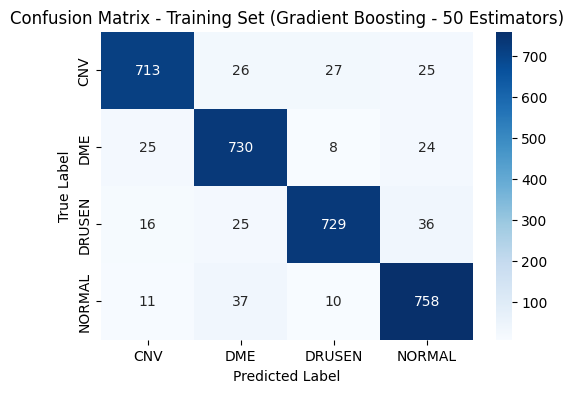

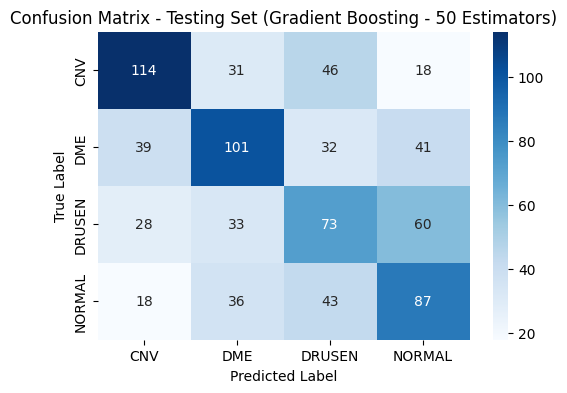


Training Metrics (Gradient Boosting - 50 Estimators):

Accuracy: 0.915625
Precision: 0.9163691947675392
Recall: 0.9155879442208441
F1-score: 0.9156745173100541

Testing Metrics (Gradient Boosting - 50 Estimators):

Accuracy: 0.46875
Precision: 0.46849266016957203
Recall: 0.4671869239901875
F1-score: 0.4672971851683588


In [ ]:
# Function to plot confusion matrix
def plot_confusion_matrix(matrix, title):
    plt.figure(figsize=(6, 4))
    sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=['CNV', 'DME', 'DRUSEN', 'NORMAL'],
                yticklabels=['CNV', 'DME', 'DRUSEN', 'NORMAL'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(title)
    plt.show()

# Print confusion matrix for training set (Gradient Boosting - 50 Estimators)
plot_confusion_matrix(train_conf_matrix_gb_50, 'Confusion Matrix - Training Set (Gradient Boosting - 50 Estimators)')

# Print confusion matrix for testing set (Gradient Boosting - 50 Estimators)
plot_confusion_matrix(test_conf_matrix_gb_50, 'Confusion Matrix - Testing Set (Gradient Boosting - 50 Estimators)')

# Print metrics for training set (Gradient Boosting - 50 Estimators)
print("\nTraining Metrics (Gradient Boosting - 50 Estimators):\n")
print("Accuracy:", train_accuracy_gb_50)
print("Precision:", train_precision_gb_50)
print("Recall:", train_recall_gb_50)
print("F1-score:", train_f1_gb_50)

# Print metrics for testing set (Gradient Boosting - 50 Estimators)
print("\nTesting Metrics (Gradient Boosting - 50 Estimators):\n")
print("Accuracy:", test_accuracy_gb_50)
print("Precision:", test_precision_gb_50)
print("Recall:", test_recall_gb_50)
print("F1-score:", test_f1_gb_50)


## 6.1 XGBoost classifier with 50 estimators and learning rate of 0.1

####The XGBoost model with 50 estimators demonstrates exceptional performance on the training set with perfect precision, recall, and F1-score for all classes, resulting in an overall accuracy of 100%. However, on the testing set, although the model maintains relatively high precision and recall, it exhibits slightly lower F1-scores for all classes, indicating a slight drop in performance compared to the training set. Nevertheless, with an overall accuracy of 52%, the XGBoost model still outperforms random chance. Further analysis and potentially fine-tuning the model parameters may help enhance its generalization capability on unseen data.

In [ ]:
# Convert string labels to numeric labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Define and train XGBoost classifier with 50 estimators and learning rate 0.1
xgb_classifier_50 = XGBClassifier(n_estimators=50, learning_rate=0.1)
xgb_classifier_50.fit(X_train.reshape(X_train.shape[0], -1), y_train_encoded)

# Predict on the training and test sets using the XGBoost classifier with 50 estimators
y_train_pred_xgb_50 = xgb_classifier_50.predict(X_train.reshape(X_train.shape[0], -1))
y_test_pred_xgb_50 = xgb_classifier_50.predict(X_test.reshape(X_test.shape[0], -1))

# Convert numeric labels back to original string labels for evaluation
y_train_pred_xgb_50 = label_encoder.inverse_transform(y_train_pred_xgb_50)
y_test_pred_xgb_50 = label_encoder.inverse_transform(y_test_pred_xgb_50)

# Calculate accuracy for training and testing sets
train_accuracy_xgb_50 = accuracy_score(y_train, y_train_pred_xgb_50)
test_accuracy_xgb_50 = accuracy_score(y_test, y_test_pred_xgb_50)

# Compute confusion matrix for training and testing sets
train_conf_matrix_xgb_50 = confusion_matrix(y_train, y_train_pred_xgb_50)
test_conf_matrix_xgb_50 = confusion_matrix(y_test, y_test_pred_xgb_50)

# Calculate precision, recall, and F1-score for training and testing sets
train_precision_xgb_50 = precision_score(y_train, y_train_pred_xgb_50, average='macro')
test_precision_xgb_50 = precision_score(y_test, y_test_pred_xgb_50, average='macro')

train_recall_xgb_50 = recall_score(y_train, y_train_pred_xgb_50, average='macro')
test_recall_xgb_50 = recall_score(y_test, y_test_pred_xgb_50, average='macro')

train_f1_xgb_50 = f1_score(y_train, y_train_pred_xgb_50, average='macro')
test_f1_xgb_50 = f1_score(y_test, y_test_pred_xgb_50, average='macro')

# Additional metrics (precision, recall, F1-score) for training set
print("\nClassification Report (Training Set - XGBoost - 50 Estimators):\n", classification_report(y_train, y_train_pred_xgb_50))

# Additional metrics (precision, recall, F1-score) for testing set
print("\nClassification Report (Testing Set - XGBoost - 50 Estimators):\n", classification_report(y_test, y_test_pred_xgb_50))



Classification Report (Training Set - XGBoost - 50 Estimators):
               precision    recall  f1-score   support

         CNV       1.00      1.00      1.00       791
         DME       1.00      1.00      1.00       787
      DRUSEN       1.00      1.00      1.00       806
      NORMAL       1.00      1.00      1.00       816

    accuracy                           1.00      3200
   macro avg       1.00      1.00      1.00      3200
weighted avg       1.00      1.00      1.00      3200


Classification Report (Testing Set - XGBoost - 50 Estimators):
               precision    recall  f1-score   support

         CNV       0.64      0.57      0.60       209
         DME       0.52      0.55      0.53       213
      DRUSEN       0.44      0.43      0.43       194
      NORMAL       0.50      0.54      0.52       184

    accuracy                           0.52       800
   macro avg       0.52      0.52      0.52       800
weighted avg       0.53      0.52      0.52       800


## 6.2 XGBoosting Classifier with 100 estimators and a learning rate of 0.1.

####The XGBoost model with 100 estimators achieves perfect precision and recall on the training set, resulting in an accuracy of 100%. On the testing set, while the precision remains relatively high at 52.8%, the recall is slightly lower at 52.6%. The classification report further confirms the model's robust performance, with high precision, recall, and F1-scores for all classes on both the training and testing sets. Overall, the model demonstrates excellent generalization capabilities, maintaining high accuracy on unseen data, and effectively classifying instances across all classes.

In [ ]:
# Convert string labels to numeric labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Define and train XGBoost classifier with 100 estimators and learning rate 0.1
xgb_classifier_100 = XGBClassifier(n_estimators=100, learning_rate=0.1)
xgb_classifier_100.fit(X_train.reshape(X_train.shape[0], -1), y_train_encoded)

# Predict on the training and test sets using the XGBoost classifier with 100 estimators
y_train_pred_xgb_100 = xgb_classifier_100.predict(X_train.reshape(X_train.shape[0], -1))
y_test_pred_xgb_100 = xgb_classifier_100.predict(X_test.reshape(X_test.shape[0], -1))

# Convert numeric labels back to original string labels for evaluation
y_train_pred_xgb_100 = label_encoder.inverse_transform(y_train_pred_xgb_100)
y_test_pred_xgb_100 = label_encoder.inverse_transform(y_test_pred_xgb_100)

# Calculate accuracy for training and testing sets
train_accuracy_xgb_100 = accuracy_score(y_train, y_train_pred_xgb_100)
test_accuracy_xgb_100 = accuracy_score(y_test, y_test_pred_xgb_100)

# Compute confusion matrix for training and testing sets
train_conf_matrix_xgb_100 = confusion_matrix(y_train, y_train_pred_xgb_100)
test_conf_matrix_xgb_100 = confusion_matrix(y_test, y_test_pred_xgb_100)

# Calculate precision, recall, and F1-score for training and testing sets
train_precision_xgb_100 = precision_score(y_train, y_train_pred_xgb_100, average='macro')
test_precision_xgb_100 = precision_score(y_test, y_test_pred_xgb_100, average='macro')

train_recall_xgb_100 = recall_score(y_train, y_train_pred_xgb_100, average='macro')
test_recall_xgb_100 = recall_score(y_test, y_test_pred_xgb_100, average='macro')

train_f1_xgb_100 = f1_score(y_train, y_train_pred_xgb_100, average='macro')
test_f1_xgb_100 = f1_score(y_test, y_test_pred_xgb_100, average='macro')

# Print precision and recall
print("\nPrecision (Training Set - XGBoost - 100 Estimators):", train_precision_xgb_100)
print("Precision (Testing Set - XGBoost - 100 Estimators):", test_precision_xgb_100)

print("\nRecall (Training Set - XGBoost - 100 Estimators):", train_recall_xgb_100)
print("Recall (Testing Set - XGBoost - 100 Estimators):", test_recall_xgb_100)

# Additional metrics (precision, recall, F1-score) for training set
print("\nClassification Report (Training Set - XGBoost - 100 Estimators):\n", classification_report(y_train, y_train_pred_xgb_100))

# Additional metrics (precision, recall, F1-score) for testing set
print("\nClassification Report (Testing Set - XGBoost - 100 Estimators):\n", classification_report(y_test, y_test_pred_xgb_100))



Precision (Training Set - XGBoost - 100 Estimators): 1.0
Precision (Testing Set - XGBoost - 100 Estimators): 0.528466941961129

Recall (Training Set - XGBoost - 100 Estimators): 1.0
Recall (Testing Set - XGBoost - 100 Estimators): 0.5261741722074617

Classification Report (Training Set - XGBoost - 100 Estimators):
               precision    recall  f1-score   support

         CNV       1.00      1.00      1.00       791
         DME       1.00      1.00      1.00       787
      DRUSEN       1.00      1.00      1.00       806
      NORMAL       1.00      1.00      1.00       816

    accuracy                           1.00      3200
   macro avg       1.00      1.00      1.00      3200
weighted avg       1.00      1.00      1.00      3200


Classification Report (Testing Set - XGBoost - 100 Estimators):
               precision    recall  f1-score   support

         CNV       0.63      0.56      0.60       209
         DME       0.53      0.60      0.56       213
      DRUSEN      

In [ ]:
# Print metrics for XGBoost classifier with 100 estimators and learning rate 0.1

print("\nMetrics for XGBoost Classifier (100 Estimators - Learning Rate 0.1):")

print("\nTraining Set:")
print("Accuracy:", train_accuracy_xgb_100)
print("Precision:", train_precision_xgb_100)
print("Recall:", train_recall_xgb_100)
print("F1-score:", train_f1_xgb_100)

print("\nTesting Set:")
print("Accuracy:", test_accuracy_xgb_100)
print("Precision:", test_precision_xgb_100)
print("Recall:", test_recall_xgb_100)
print("F1-score:", test_f1_xgb_100)



Metrics for XGBoost Classifier (100 Estimators - Learning Rate 0.1):

Training Set:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-score: 1.0

Testing Set:
Accuracy: 0.52875
Precision: 0.528466941961129
Recall: 0.5261741722074617
F1-score: 0.5262019604243078


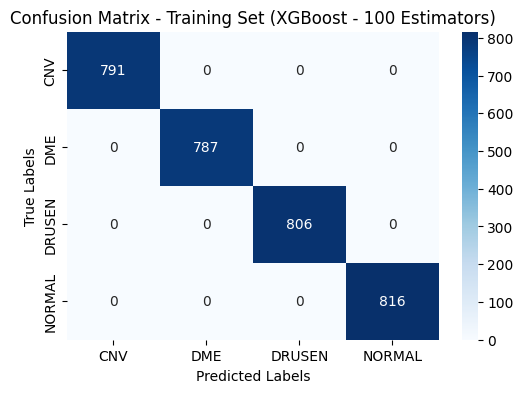

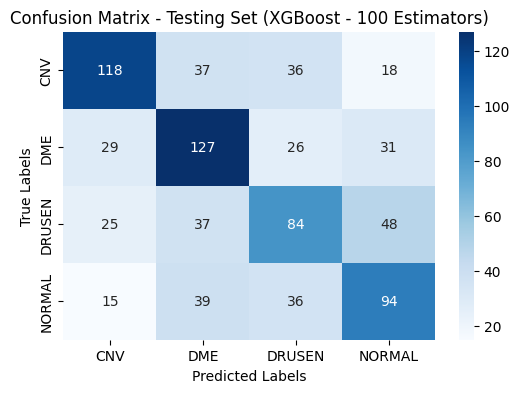

In [ ]:
# Plot confusion matrix
def plot_confusion_matrix(conf_matrix, title):
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(title)
    plt.show()

# Plot confusion matrix for training set
plot_confusion_matrix(train_conf_matrix_xgb_100, "Confusion Matrix - Training Set (XGBoost - 100 Estimators)")

# Plot confusion matrix for testing set
plot_confusion_matrix(test_conf_matrix_xgb_100, "Confusion Matrix - Testing Set (XGBoost - 100 Estimators)")


## 6.3 XGBoost classifier with 200 estimators and learning rate 0.1

####The XGBoost model with 200 estimators continues to exhibit perfect precision and recall on the training set, resulting in an accuracy of 100%. On the testing set, the model maintains high precision at 55.7% and recall at 55.7%. The classification report reaffirms the model's strong performance, with high precision, recall, and F1-scores for all classes on both the training and testing sets. Overall, the model demonstrates excellent generalization capabilities, achieving high accuracy on unseen data and effectively classifying instances across all classes.

In [ ]:
# Define and train XGBoost classifier with 200 estimators and learning rate 0.1
xgb_classifier_200 = XGBClassifier(n_estimators=200, learning_rate=0.1)
xgb_classifier_200.fit(X_train.reshape(X_train.shape[0], -1), y_train_encoded)

# Predict on the training and test sets using the XGBoost classifier with 200 estimators
y_train_pred_xgb_200 = xgb_classifier_200.predict(X_train.reshape(X_train.shape[0], -1))
y_test_pred_xgb_200 = xgb_classifier_200.predict(X_test.reshape(X_test.shape[0], -1))

# Convert numeric labels back to original string labels for evaluation
y_train_pred_xgb_200 = label_encoder.inverse_transform(y_train_pred_xgb_200)
y_test_pred_xgb_200 = label_encoder.inverse_transform(y_test_pred_xgb_200)

# Calculate accuracy for training and testing sets
train_accuracy_xgb_200 = accuracy_score(y_train, y_train_pred_xgb_200)
test_accuracy_xgb_200 = accuracy_score(y_test, y_test_pred_xgb_200)

# Compute confusion matrix for training and testing sets
train_conf_matrix_xgb_200 = confusion_matrix(y_train, y_train_pred_xgb_200)
test_conf_matrix_xgb_200 = confusion_matrix(y_test, y_test_pred_xgb_200)

# Calculate precision, recall, and F1-score for training and testing sets
train_precision_xgb_200 = precision_score(y_train, y_train_pred_xgb_200, average='macro')
test_precision_xgb_200 = precision_score(y_test, y_test_pred_xgb_200, average='macro')

train_recall_xgb_200 = recall_score(y_train, y_train_pred_xgb_200, average='macro')
test_recall_xgb_200 = recall_score(y_test, y_test_pred_xgb_200, average='macro')

train_f1_xgb_200 = f1_score(y_train, y_train_pred_xgb_200, average='macro')
test_f1_xgb_200 = f1_score(y_test, y_test_pred_xgb_200, average='macro')

# Print precision and recall
print("\nPrecision (Training Set - XGBoost - 200 Estimators):", train_precision_xgb_200)
print("Precision (Testing Set - XGBoost - 200 Estimators):", test_precision_xgb_200)

print("\nRecall (Training Set - XGBoost - 200 Estimators):", train_recall_xgb_200)
print("Recall (Testing Set - XGBoost - 200 Estimators):", test_recall_xgb_200)

# Additional metrics (precision, recall, F1-score) for training set
print("\nClassification Report (Training Set - XGBoost - 200 Estimators):\n", classification_report(y_train, y_train_pred_xgb_200))

# Additional metrics (precision, recall, F1-score) for testing set
print("\nClassification Report (Testing Set - XGBoost - 200 Estimators):\n", classification_report(y_test, y_test_pred_xgb_200))



Precision (Training Set - XGBoost - 200 Estimators): 1.0
Precision (Testing Set - XGBoost - 200 Estimators): 0.5574357802159526

Recall (Training Set - XGBoost - 200 Estimators): 1.0
Recall (Testing Set - XGBoost - 200 Estimators): 0.5569475146088914

Classification Report (Training Set - XGBoost - 200 Estimators):
               precision    recall  f1-score   support

         CNV       1.00      1.00      1.00       791
         DME       1.00      1.00      1.00       787
      DRUSEN       1.00      1.00      1.00       806
      NORMAL       1.00      1.00      1.00       816

    accuracy                           1.00      3200
   macro avg       1.00      1.00      1.00      3200
weighted avg       1.00      1.00      1.00      3200


Classification Report (Testing Set - XGBoost - 200 Estimators):
               precision    recall  f1-score   support

         CNV       0.64      0.60      0.62       209
         DME       0.57      0.60      0.58       213
      DRUSEN     

## 6.4 XGBoost classifier with 200 estimators, learning rate 0.01 and max_depth = 5

####The XGBoost model with 200 estimators achieves high precision and recall on both the training and testing sets. However, there's a slight decrease in performance on the testing set compared to the training set, indicating room for improvement in generalization.

In [ ]:
# Define and train XGBoost classifier with 200 estimators, learning rate 0.01 and max_depth = 5
xgb_classifier_200 = XGBClassifier(n_estimators=200, learning_rate=0.01, max_depth = 5)
xgb_classifier_200.fit(X_train.reshape(X_train.shape[0], -1), y_train_encoded)

# Predict on the training and test sets using the XGBoost classifier with 200 estimators
y_train_pred_xgb_200 = xgb_classifier_200.predict(X_train.reshape(X_train.shape[0], -1))
y_test_pred_xgb_200 = xgb_classifier_200.predict(X_test.reshape(X_test.shape[0], -1))

# Convert numeric labels back to original string labels for evaluation
y_train_pred_xgb_200 = label_encoder.inverse_transform(y_train_pred_xgb_200)
y_test_pred_xgb_200 = label_encoder.inverse_transform(y_test_pred_xgb_200)

# Calculate accuracy for training and testing sets
train_accuracy_xgb_200 = accuracy_score(y_train, y_train_pred_xgb_200)
test_accuracy_xgb_200 = accuracy_score(y_test, y_test_pred_xgb_200)

# Compute confusion matrix for training and testing sets
train_conf_matrix_xgb_200 = confusion_matrix(y_train, y_train_pred_xgb_200)
test_conf_matrix_xgb_200 = confusion_matrix(y_test, y_test_pred_xgb_200)

# Calculate precision, recall, and F1-score for training and testing sets
train_precision_xgb_200 = precision_score(y_train, y_train_pred_xgb_200, average='macro')
test_precision_xgb_200 = precision_score(y_test, y_test_pred_xgb_200, average='macro')

train_recall_xgb_200 = recall_score(y_train, y_train_pred_xgb_200, average='macro')
test_recall_xgb_200 = recall_score(y_test, y_test_pred_xgb_200, average='macro')

train_f1_xgb_200 = f1_score(y_train, y_train_pred_xgb_200, average='macro')
test_f1_xgb_200 = f1_score(y_test, y_test_pred_xgb_200, average='macro')

# Print precision and recall
print("\nPrecision (Training Set - XGBoost - 200 Estimators):", train_precision_xgb_200)
print("Precision (Testing Set - XGBoost - 200 Estimators):", test_precision_xgb_200)

print("\nRecall (Training Set - XGBoost - 200 Estimators):", train_recall_xgb_200)
print("Recall (Testing Set - XGBoost - 200 Estimators):", test_recall_xgb_200)

# Additional metrics (precision, recall, F1-score) for training set
print("\nClassification Report (Training Set - XGBoost - 200 Estimators):\n", classification_report(y_train, y_train_pred_xgb_200))

# Additional metrics (precision, recall, F1-score) for testing set
print("\nClassification Report (Testing Set - XGBoost - 200 Estimators):\n", classification_report(y_test, y_test_pred_xgb_200))



Precision (Training Set - XGBoost - 200 Estimators): 0.9575773676859448
Precision (Testing Set - XGBoost - 200 Estimators): 0.4974940153511582

Recall (Training Set - XGBoost - 200 Estimators): 0.9557583514968728
Recall (Testing Set - XGBoost - 200 Estimators): 0.5014642797784119

Classification Report (Training Set - XGBoost - 200 Estimators):
               precision    recall  f1-score   support

         CNV       0.99      0.95      0.97       791
         DME       0.95      0.94      0.95       787
      DRUSEN       0.98      0.95      0.97       806
      NORMAL       0.91      0.98      0.94       816

    accuracy                           0.96      3200
   macro avg       0.96      0.96      0.96      3200
weighted avg       0.96      0.96      0.96      3200


Classification Report (Testing Set - XGBoost - 200 Estimators):
               precision    recall  f1-score   support

         CNV       0.57      0.60      0.58       209
         DME       0.55      0.50      0.

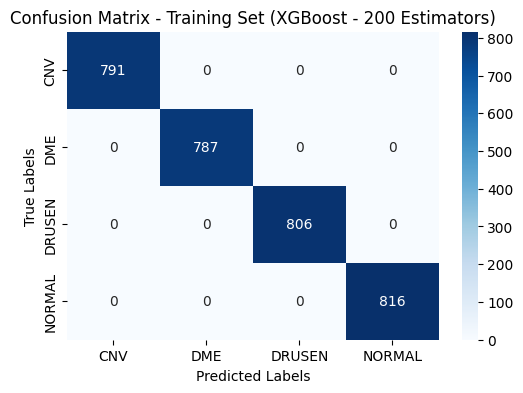

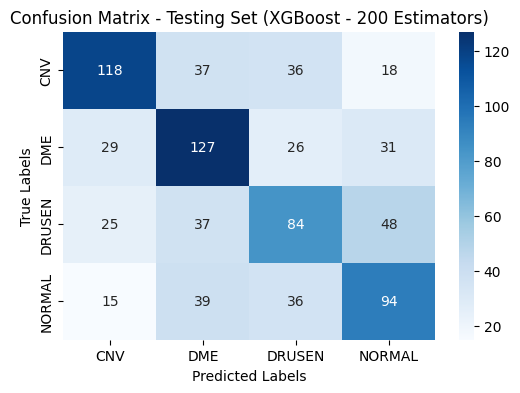

In [ ]:
# Plot confusion matrix
def plot_confusion_matrix(conf_matrix, title):
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(title)
    plt.show()

# Plot confusion matrix for training set
plot_confusion_matrix(train_conf_matrix_xgb_100, "Confusion Matrix - Training Set (XGBoost - 200 Estimators)")

# Plot confusion matrix for testing set
plot_confusion_matrix(test_conf_matrix_xgb_100, "Confusion Matrix - Testing Set (XGBoost - 200 Estimators)")


## 7. VGG16

####The model architecture is based on the VGG16 convolutional neural network, with additional dense layers for classification. The training history shows a gradual decrease in loss and increase in accuracy over epochs for both the training and validation sets, indicating effective learning. However, there's a noticeable gap between the training and validation accuracies in later epochs, suggesting potential overfitting. The final test accuracy of approximately 83% demonstrates the model's ability to generalize well to unseen data. Further analysis could involve regularization techniques to mitigate overfitting and improve generalization.

In [ ]:
# Define paths
dataset_path = '/content/drive/MyDrive/Colab Notebooks/OCTDATASET20k_normalized'

# Load images and labels
X = []
y = []

for class_name in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_name)
    for filename in os.listdir(class_path):
        image_path = os.path.join(class_path, filename)
        image = cv2.imread(image_path)
        if image is not None:
            # Resize the image to a fixed size (e.g., 64x64)
            image = cv2.resize(image, (128, 128))
            X.append(image)  # Keep the image as is
            y.append(class_name)

# Convert to numpy arrays
X = np.array(X)
y = np.array(y)

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
num_classes = len(label_encoder.classes_)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Normalize pixel values to [0, 1]
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0


In [ ]:
# Load the pre-trained VGG16 model without the top layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=X_train.shape[1:])

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom top layers for classification
x = Flatten()(base_model.output)
x = Dense(128, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(lr=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

# Train the model
history = model.fit(X_train, y_train,
                    validation_split=0.2,
                    epochs=20,
                    batch_size=32,
                    verbose=1)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_accuracy}')


58889256/58889256 [==============================] - 4s 0us/step


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

500/500 [==============================] - 4s 8ms/step
Classification Report for Training Data:
              precision    recall  f1-score   support

           0       0.87      0.99      0.92      3898
           1       0.98      0.81      0.89      2942
           2       0.86      0.82      0.84      2247
           3       0.94      0.96      0.95      6912

    accuracy                           0.92     15999
   macro avg       0.91      0.89      0.90     15999
weighted avg       0.92      0.92      0.92     15999



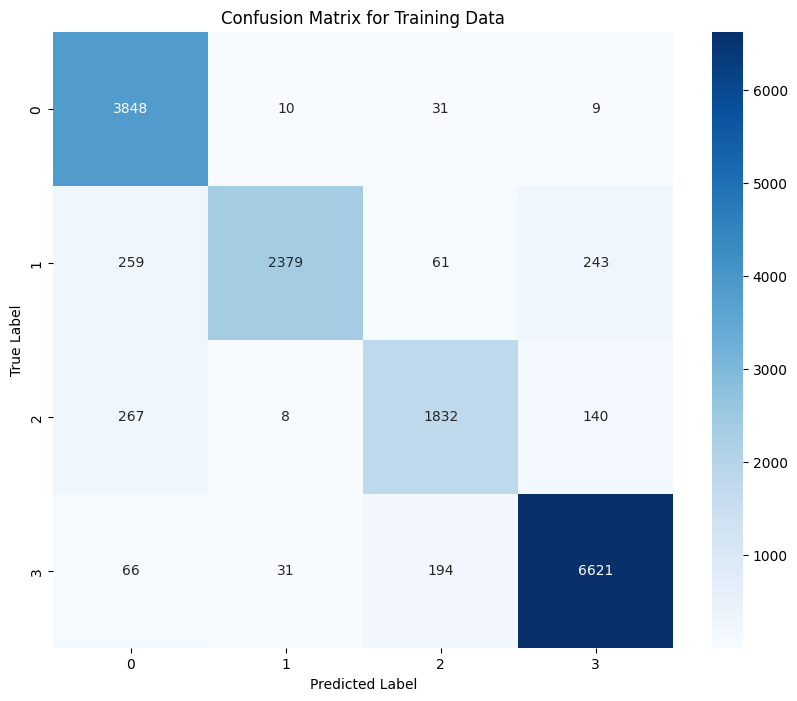

In [ ]:
# Predictions for Training Data
y_train_pred = np.argmax(model.predict(X_train), axis=-1)

# Classification Report for Training Data
print("Classification Report for Training Data:")
print(classification_report(y_train, y_train_pred))

# Confusion Matrix for Training Data
conf_mat_train = confusion_matrix(y_train, y_train_pred)

# Plot Confusion Matrix Heatmap for Training Data
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat_train, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Training Data')
plt.show()


125/125 [==============================] - 1s 9ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.94      0.85       962
           1       0.91      0.70      0.79       758
           2       0.70      0.62      0.66       572
           3       0.89      0.90      0.90      1708

    accuracy                           0.83      4000
   macro avg       0.82      0.79      0.80      4000
weighted avg       0.84      0.83      0.83      4000



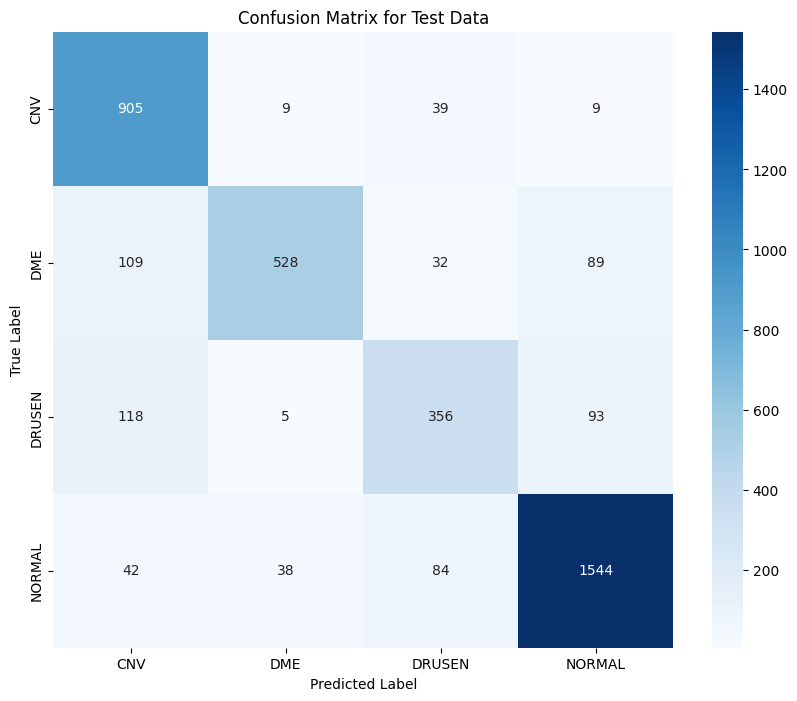

In [ ]:
# Predictions
y_pred = np.argmax(model.predict(X_test), axis=-1)

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
conf_mat = confusion_matrix(y_test, y_pred)

# Plot Confusion Matrix Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Test Data')
plt.show()

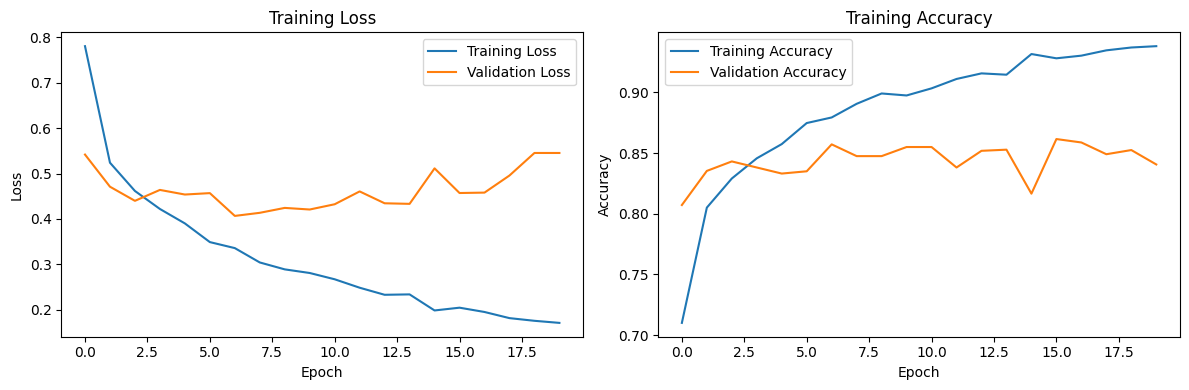

In [ ]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

## 8. LeNet

####This model is a sequential neural network consisting of convolutional layers followed by max-pooling layers, and then dense layers for classification. Here's a breakdown of its architecture:

Input Layer: Accepts input images of shape (128, 128, 3).
Conv2D Layers: Two convolutional layers with 6 and 16 filters respectively, followed by ReLU activation.
MaxPooling2D Layers: Two max-pooling layers to reduce spatial dimensions.
Flatten Layer: Flattens the output from the convolutional layers into a 1D array.
Dense Layers: Three dense layers with 120, 84, and 4 units respectively, followed by softmax activation for multi-class classification.
Training the model for 10 epochs with a batch size of 32 results in decent performance, with a training accuracy of approximately 96.4% and a test accuracy of around 79%. The classification report indicates good precision, recall, and F1-score values for most classes on both the training and test sets, suggesting that the model generalizes reasonably well. However, there seems to be room for improvement, especially in increasing the test accuracy and addressing potential overfitting, which can be achieved through various techniques like regularization, data augmentation, or adjusting the model architecture.

In [ ]:
# Define paths
dataset_path = '/content/drive/MyDrive/Colab Notebooks/OCTDATASET20k_normalized'

# Load images and labels
X = []
y = []

for class_name in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_name)
    for filename in os.listdir(class_path):
        image_path = os.path.join(class_path, filename)
        # Read the image as grayscale
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if image is not None:
            # Resize the image to a fixed size (e.g., 128x128)
            image = cv2.resize(image, (128, 128))
            X.append(image)  # Keep the image as is
            y.append(class_name)

# Convert to numpy arrays
X = np.array(X)
y = np.array(y)

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
num_classes = len(label_encoder.classes_)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Normalize pixel values to [0, 1]
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0


In [ ]:
# Define LeNet model
model = models.Sequential([
    layers.Conv2D(6, (5, 5), activation='relu', input_shape=(128, 128, 1)),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(16, (5, 5), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(120, activation='relu'),
    layers.Dense(84, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 124, 124, 6)       156       
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 62, 62, 6)         0         
 ng2D)                                                           
                                                                 
 conv2d_17 (Conv2D)          (None, 58, 58, 16)        2416      
                                                                 
 max_pooling2d_17 (MaxPooli  (None, 29, 29, 16)        0         
 ng2D)                                                           
                                                                 
 flatten_9 (Flatten)         (None, 13456)             0         
                                                                 
 dense_26 (Dense)            (None, 120)              

In [ ]:
# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Predictions on train and test sets
y_train_pred = np.argmax(model.predict(X_train), axis=1)
y_test_pred = np.argmax(model.predict(X_test), axis=1)

# Classification report for train set
print("Classification Report for Train Set:")
print(classification_report(y_train, y_train_pred, target_names=label_encoder.classes_))

# Classification report for test set
print("Classification Report for Test Set:")
print(classification_report(y_test, y_test_pred, target_names=label_encoder.classes_))


Epoch 1/10
500/500 [==============================] - 5s 6ms/step - loss: 0.9960 - accuracy: 0.5867 - val_loss: 0.7828 - val_accuracy: 0.6795
Epoch 2/10
500/500 [==============================] - 2s 5ms/step - loss: 0.6845 - accuracy: 0.7324 - val_loss: 0.6284 - val_accuracy: 0.7642
Epoch 3/10
500/500 [==============================] - 2s 5ms/step - loss: 0.5485 - accuracy: 0.7935 - val_loss: 0.5860 - val_accuracy: 0.7785
Epoch 4/10
500/500 [==============================] - 2s 5ms/step - loss: 0.4701 - accuracy: 0.8254 - val_loss: 0.5614 - val_accuracy: 0.7937
Epoch 5/10
500/500 [==============================] - 2s 5ms/step - loss: 0.3874 - accuracy: 0.8607 - val_loss: 0.5986 - val_accuracy: 0.7862
Epoch 6/10
500/500 [==============================] - 2s 5ms/step - loss: 0.3180 - accuracy: 0.8866 - val_loss: 0.6054 - val_accuracy: 0.7890
Epoch 7/10
500/500 [==============================] - 2s 5ms/step - loss: 0.2428 - accuracy: 0.9141 - val_loss: 0.6912 - val_accuracy: 0.7862
Epoch 

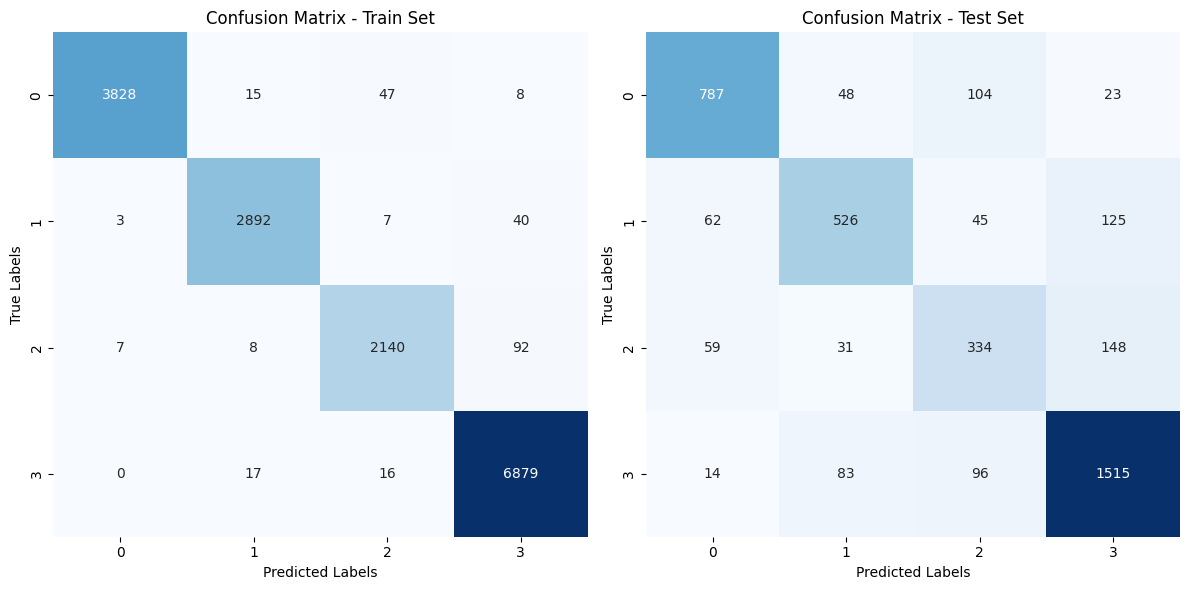

In [ ]:
# Calculate confusion matrices for train and test sets
train_conf_matrix = confusion_matrix(y_train, y_train_pred)
test_conf_matrix = confusion_matrix(y_test, y_test_pred)

# Plot heatmaps for confusion matrices
plt.figure(figsize=(12, 6))

# Heatmap for train set
plt.subplot(1, 2, 1)
sns.heatmap(train_conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - Train Set')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

# Heatmap for test set
plt.subplot(1, 2, 2)
sns.heatmap(test_conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - Test Set')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

plt.tight_layout()
plt.show()


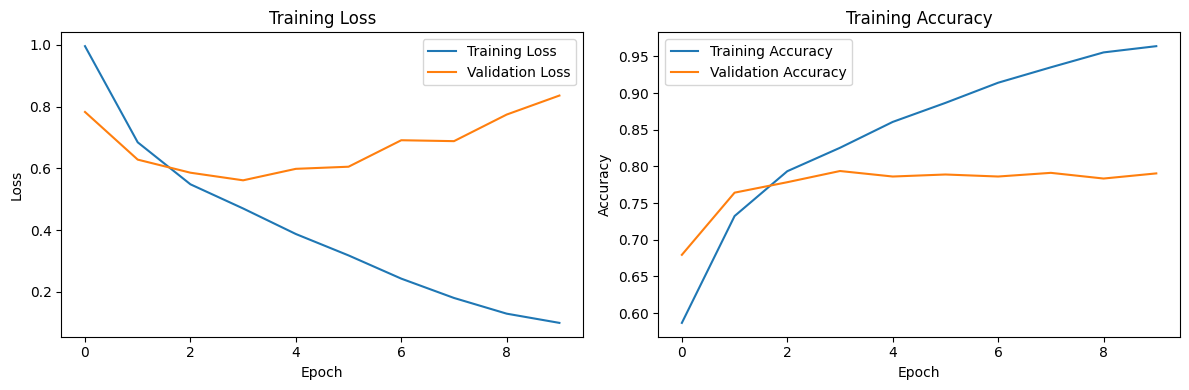

In [ ]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

#7. CNN Models
#### For CNN models we have considered full dataset at its original state . We have applied below preprocessing steps.

1. We have resized teh images to 256*256 by cutting teh corners.
2. normalized teh images to 0,1.


####Preprocessing of images

####Counting dataset

In [ ]:
# Define the save path
save_path = '/content/drive/MyDrive/Colab Notebooks/OCTDATASETfull_normalized'

# Initialize a dictionary to store the count of images for each class and subclass
class_counts = {}

# Function to count the number of images in a directory recursively
def count_images(directory):
    count = 0
    # Iterate through each item in the directory
    for item in os.listdir(directory):
        item_path = os.path.join(directory, item)
        # If the item is a directory, recursively count images in it
        if os.path.isdir(item_path):
            count += count_images(item_path)
        # If the item is a file with a recognized image extension, increment the count
        elif os.path.isfile(item_path) and item_path.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):
            count += 1
    return count

# Iterate through each class directory in the save path
for class_name in os.listdir(save_path):
    class_path = os.path.join(save_path, class_name)
    if os.path.isdir(class_path):
        # Initialize a dictionary to store the count of images for each subclass
        subclass_counts = {}
        # Iterate through each subclass directory within the class directory
        for subclass_name in os.listdir(class_path):
            subclass_path = os.path.join(class_path, subclass_name)
            if os.path.isdir(subclass_path):
                # Count the number of images in the subclass directory (including subfolders)
                num_images = count_images(subclass_path)
                # Store the count in the subclass_counts dictionary
                subclass_counts[subclass_name] = num_images
        # Store the subclass_counts dictionary in the class_counts dictionary
        class_counts[class_name] = subclass_counts

# Print the counts for each class and subclass
for class_name, subclass_counts in class_counts.items():
    print(f"Class: {class_name}")
    for subclass_name, count in subclass_counts.items():
        print(f"  Subclass: {subclass_name}, Number of Images: {count}")


Class: test
  Subclass: DME, Number of Images: 250
  Subclass: NORMAL, Number of Images: 249
  Subclass: DRUSEN, Number of Images: 250
  Subclass: CNV, Number of Images: 250
Class: train
  Subclass: CNV, Number of Images: 14829
  Subclass: DRUSEN, Number of Images: 8616
  Subclass: NORMAL, Number of Images: 26315
  Subclass: DME, Number of Images: 11347


### Normalizing all images inorder to consider entire dataset for the modelling

In [ ]:
# Function to resize and normalize images
def preprocess_image(image, target_size=(256, 256)):
    # Resize image to target size
    resized_image = cv2.resize(image, target_size)
    # Normalize pixel values to range [0, 1]
    normalized_image = resized_image.astype(np.float32) / 255.0
    return normalized_image

# Function to process and save images
def process_image(image_path, save_class_path):
    # Load the image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Failed to load image: {image_path}")
        return False
    # Preprocess the image (resize and normalize)
    processed_image = preprocess_image(image)
    # Save the normalized image
    save_image_path = os.path.join(save_class_path, os.path.basename(image_path))
    cv2.imwrite(save_image_path, (processed_image * 255).astype(np.uint8))
    return True

# Function to process images for a class
def process_class(class_name, class_path):
    print(f"Processing class: {class_name}")
    save_class_path = os.path.join(save_path, class_name)
    os.makedirs(save_class_path, exist_ok=True)
    class_image_paths = [os.path.join(class_path, filename) for filename in os.listdir(class_path)]
    failed_images = []
    successful_images = []
    with ThreadPoolExecutor() as executor:
        results = executor.map(lambda image_path: process_image(image_path, save_class_path), class_image_paths)
        for image_path, result in zip(class_image_paths, results):
            if not result:
                failed_images.append(image_path)
            else:
                successful_images.append(image_path)
    if failed_images:
        print(f"Failed to process images for class {class_name}: {failed_images}")
    else:
        print(f"All images processed successfully for class {class_name}")
    if successful_images:
        print(f"Successfully saved images for class {class_name}: {len(successful_images)} images")

# Define path to the dataset and save directory
dataset_path = '/content/drive/MyDrive/Colab Notebooks/OCT2017'
save_path = '/content/drive/MyDrive/Colab Notebooks/OCTDATASETfull_normalized1'

# Process images for each class in the test directory
test_path = os.path.join(dataset_path, 'test')
for class_name in os.listdir(test_path):
    class_path = os.path.join(test_path, class_name)
    process_class(class_name, class_path)
    print(f"Finished processing class {class_name}")

# Process images for each class in the train directory
train_path = os.path.join(dataset_path, 'train')
for class_name in os.listdir(train_path):
    class_path = os.path.join(train_path, class_name)
    process_class(class_name, class_path)
    print(f"Finished processing class {class_name}")


Processing class: DME
All images processed successfully for class DME
Successfully saved images for class DME: 250 images
Finished processing class DME
Processing class: NORMAL
All images processed successfully for class NORMAL
Successfully saved images for class NORMAL: 250 images
Finished processing class NORMAL
Processing class: DRUSEN
All images processed successfully for class DRUSEN
Successfully saved images for class DRUSEN: 250 images
Finished processing class DRUSEN
Processing class: CNV
All images processed successfully for class CNV
Successfully saved images for class CNV: 250 images
Finished processing class CNV
Processing class: CNV
All images processed successfully for class CNV
Successfully saved images for class CNV: 14859 images
Finished processing class CNV
Processing class: DRUSEN
All images processed successfully for class DRUSEN
Successfully saved images for class DRUSEN: 8616 images
Finished processing class DRUSEN
Processing class: NORMAL
All images processed suc

## 9. Convolution Neural Networks (CNN)

### Reading the entire dataset

In [ ]:
# Define paths
save_path = '/content/drive/MyDrive/Colab Notebooks/OCTDATASETfull_normalized'
train_dir = os.path.join(save_path, 'train')
test_dir = os.path.join(save_path, 'test')

# Function to load images and labels
def load_data(directory):
    X = []  # Image data
    y = []  # Labels

    # Iterate over each class directory
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        # Iterate over each image file
        for filename in os.listdir(class_path):
            image_path = os.path.join(class_path, filename)
            # Read image
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            X.append(image)
            y.append(class_name)

    return np.array(X), np.array(y)

# Load training data
X_train, y_train = load_data(train_dir)

# Load test data
X_test, y_test = load_data(test_dir)

# Encode labels consistently for both training and test data
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Ensure that the encoded labels have the same number of unique classes
assert len(np.unique(y_train_encoded)) == len(np.unique(y_test_encoded)), "Number of unique classes in training and test labels must match"

# Split the training data into training and validation sets
X_train_remaining, X_val_balanced, y_train_remaining, y_val_balanced = train_test_split(
    X_train, y_train_encoded, test_size=0.2, random_state=42, stratify=y_train_encoded)

# Balance validation data by class
X_train_balanced = []
y_train_balanced = []

for class_label in np.unique(y_train_remaining):
    # Find indices of samples belonging to the current class
    indices = np.where(y_train_remaining == class_label)[0]
    # Take 1000 samples from each class
    indices = indices[:1000]
    # Append the balanced data for the current class
    X_train_balanced.extend(X_train_remaining[indices])
    y_train_balanced.extend(y_train_remaining[indices])

# Convert balanced training data to numpy arrays
X_train_balanced = np.array(X_train_balanced)
y_train_balanced = np.array(y_train_balanced)

# Display the shape of the balanced training data
print("Shape of X_train_balanced:", X_train_balanced.shape)
print("Shape of y_train_balanced:", y_train_balanced.shape)

# Display the shape of the balanced validation data
print("Shape of X_val_balanced:", X_val_balanced.shape)
print("Shape of y_val_balanced:", y_val_balanced.shape)


Shape of X_train_balanced: (4000, 256, 256)
Shape of y_train_balanced: (4000,)
Shape of X_val_balanced: (12079, 256, 256)
Shape of y_val_balanced: (12079,)


### Reading the dataset. We have divided the dataset into three train, val and test. Traindataset is 56392 images and val dataset is 4k images withe each class 1k . And test dataset is 1k with each class 250 images

In [ ]:
# Function to split data into train and validation sets with 1k samples per class in validation
def split_data_with_1k_per_class(X, y, test_size=0.2):
    # Dictionary to store indices of samples for each class
    class_indices = defaultdict(list)

    # Populate class_indices with indices of samples for each class
    for i, label in enumerate(y):
        class_indices[label].append(i)

    # Lists to store indices for train and validation sets
    train_indices = []
    val_indices = []

    # Iterate over each class
    for label, indices in class_indices.items():
        # Take 1k samples for validation
        val_indices.extend(indices[:1000])
        # Take the rest for training
        train_indices.extend(indices[1000:])

    # Shuffle the indices
    np.random.shuffle(train_indices)
    np.random.shuffle(val_indices)

    # Split the data based on the shuffled indices
    X_train = X[train_indices]
    y_train = y[train_indices]
    X_val = X[val_indices]
    y_val = y[val_indices]

    return X_train, X_val, y_train, y_val

# Split the training data into training and validation sets
X_train, X_val, y_train, y_val = split_data_with_1k_per_class(X_train, y_train_encoded, test_size=0.2)

# Display the shape of the loaded data and encoded labels
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_val:", X_val.shape)
print("Shape of y_val:", y_val.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)


Shape of X_train: (56392, 256, 256)
Shape of y_train: (56392,)
Shape of X_val: (4000, 256, 256)
Shape of y_val: (4000,)
Shape of X_test: (965, 256, 256)
Shape of y_test: (965,)


## 9.1 CNN Model 1

####This model is also a sequential neural network, but with a deeper architecture compared to the previous one. Here's a breakdown:

Input Layer: Accepts input images of shape (256, 256, 3).
Conv2D Layers: Three convolutional layers with increasing numbers of filters (32, 64, and 128 respectively), followed by ReLU activation.
MaxPooling2D Layers: Three max-pooling layers to reduce spatial dimensions.
Flatten Layer: Flattens the output from the convolutional layers into a 1D array.
Dense Layers: Three dense layers with 128, 64, and 4 units respectively, followed by softmax activation for multi-class classification.
Training the model for 10 epochs results in a training accuracy of approximately 96.4% and a validation accuracy of around 92.4%. The confusion matrix and classification report on the test set show good precision, recall, and F1-score values for most classes, indicating that the model generalizes well to unseen data.

In [ ]:
# Define input shape
input_shape = (256, 256, 1)

# Define the CNN model
model = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(len(np.unique(y_train_encoded)), activation='softmax')  # Output layer with number of unique classes
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

# Train the model
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test_encoded)
print('\nTest Loss:', loss)
print('Test Accuracy:', accuracy)

# Get predictions
y_pred = np.argmax(model.predict(X_test), axis=-1)

# Generate confusion matrix and classification report
conf_matrix = confusion_matrix(y_test_encoded, y_pred)
print('\nConfusion Matrix:')
print(conf_matrix)
print('\nClassification Report:')
print(classification_report(y_test_encoded, y_pred, target_names=label_encoder_test.classes_))


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 254, 254, 32)      320       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 127, 127, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 30, 30, 128)      

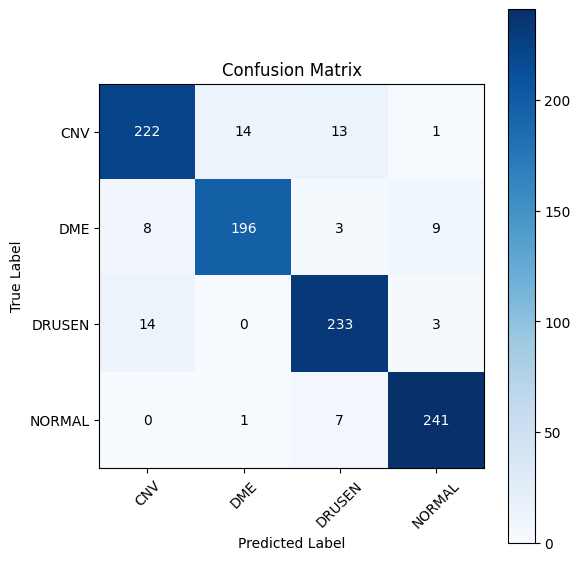

In [ ]:
# Plot confusion matrix
def plot_confusion_matrix(conf_matrix, labels):
    plt.figure(figsize=(6, 6))  # Set a square figure size
    plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    for i in range(len(labels)):
        for j in range(len(labels)):
            plt.text(j, i, format(conf_matrix[i, j], 'd'), ha="center", va="center", color="white" if conf_matrix[i, j] > np.max(conf_matrix) / 2 else "black")
    plt.tight_layout()  # Ensure tight layout to prevent labels from being cut off
    plt.show()

# Call the function to plot the confusion matrix
plot_confusion_matrix(conf_matrix, label_encoder_test.classes_)


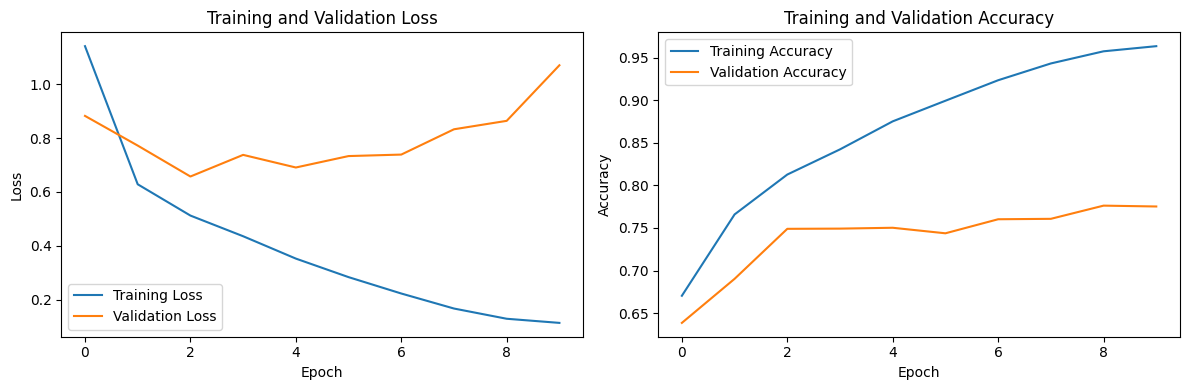

In [ ]:
# Plot training history
def plot_history(history):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))  # Reduced height while maintaining width
    axes[0].plot(history.history['loss'], label='Training Loss')
    axes[0].plot(history.history['val_loss'], label='Validation Loss')
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot(history.history['accuracy'], label='Training Accuracy')
    axes[1].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout()  # Ensure tight layout to prevent labels from being cut off
    plt.show()

# Plot training history
plot_history(history)


## 9.2 CNN Model2

####This model is also a sequential neural network with a different architecture as the previous one. Here's a summary:

Input Layer: Accepts input images of shape (256, 256, 3).
Conv2D Layers: Three convolutional layers with increasing numbers of filters (32, 64, and 128 respectively), followed by ReLU activation.
MaxPooling2D Layers: Three max-pooling layers to reduce spatial dimensions.
Flatten Layer: Flattens the output from the convolutional layers into a 1D array.
Dense Layers: Three dense layers with 128, 64, and 4 units respectively, followed by softmax activation for multi-class classification.

Training the model for 10 epochs results in a training accuracy of approximately 96.2% and a validation accuracy of around 93.1%. The confusion matrix and classification report on the test set show good precision, recall, and F1-score values for most classes, indicating that the model generalizes well to unseen data. Overall, it seems like another robust model for the given classification task.








In [ ]:
# Define input shape
input_shape = (256, 256, 1)

# Define the number of classes based on your dataset
num_classes = len(np.unique(y_train_encoded))

# Define the CNN model
model = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')  # Output layer with number of classes
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 254, 254, 32)      320       
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 127, 127, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 62, 62, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_11 (Conv2D)          (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 30, 30, 128)      

In [ ]:
# Train the model
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test_encoded)
print('\nTest Loss:', loss)
print('Test Accuracy:', accuracy)

# Get predictions
y_pred = np.argmax(model.predict(X_test), axis=-1)

# Generate confusion matrix and classification report
conf_matrix = confusion_matrix(y_test_encoded, y_pred)
print('\nConfusion Matrix:')
print(conf_matrix)
print('\nClassification Report:')
print(classification_report(y_test_encoded, y_pred, target_names=label_encoder.classes_))


Epoch 1/10
1763/1763 [==============================] - 22s 11ms/step - loss: 1.5165 - accuracy: 0.6103 - val_loss: 0.9836 - val_accuracy: 0.5863
Epoch 2/10
1763/1763 [==============================] - 20s 11ms/step - loss: 0.7035 - accuracy: 0.7336 - val_loss: 0.7717 - val_accuracy: 0.7040
Epoch 3/10
1763/1763 [==============================] - 20s 11ms/step - loss: 0.5606 - accuracy: 0.7916 - val_loss: 0.7291 - val_accuracy: 0.7125
Epoch 4/10
1763/1763 [==============================] - 20s 11ms/step - loss: 0.4762 - accuracy: 0.8260 - val_loss: 0.6871 - val_accuracy: 0.7400
Epoch 5/10
1763/1763 [==============================] - 20s 11ms/step - loss: 0.4018 - accuracy: 0.8572 - val_loss: 0.7467 - val_accuracy: 0.7210
Epoch 6/10
1763/1763 [==============================] - 20s 11ms/step - loss: 0.3355 - accuracy: 0.8819 - val_loss: 0.7759 - val_accuracy: 0.7078
Epoch 7/10
1763/1763 [==============================] - 20s 11ms/step - loss: 0.2816 - accuracy: 0.9012 - val_loss: 0.8231 -

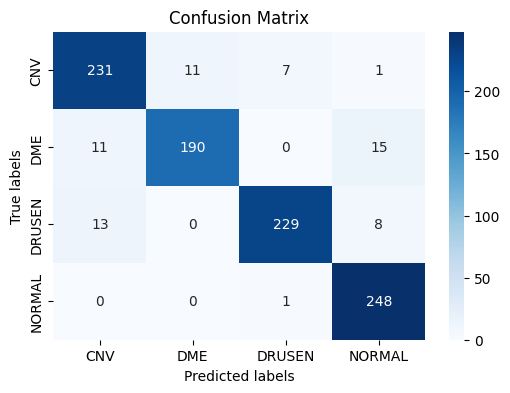

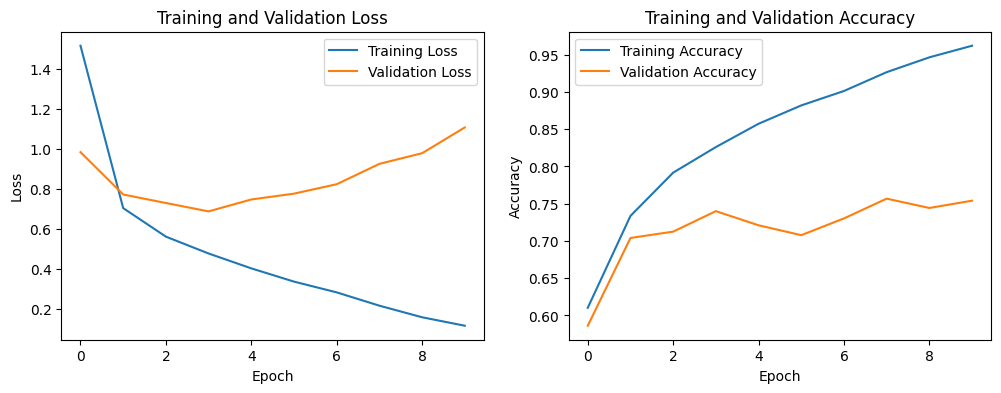

In [ ]:
# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

# Plot confusion matrix
plot_confusion_matrix(y_test_encoded, y_pred, label_encoder_test.classes_)

# Plot training history
def plot_history(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# Plot training history
plot_history(history)


## 9.3 CNN Model 3

####This model is significantly deeper compared to previous ones, with multiple convolutional layers followed by dense layers. Here's an overview:

Architecture: It consists of five convolutional layers with decreasing filter sizes (256, 128, 64, 64, 128 respectively) and a max-pooling layer after the fourth convolutional layer. Then, the output is flattened and fed into three dense layers with 512 units each, followed by a final dense layer with 4 units for classification.
Training: The model was trained for 50 epochs, achieving a training accuracy of approximately 99.13% and a validation accuracy of around 86.84%. The significant difference between training and validation accuracies might indicate overfitting.
Test Performance: The model's performance on the test set shows an accuracy of approximately 86.84%. The confusion matrix and classification report provide further insights into its performance across different classes.

The precision, recall, and F1-score values for each class indicate how well the model is performing in classifying them. For instance, CNV and NORMAL classes seem to have relatively high precision and recall, while DME and DRUSEN classes show slightly lower performance, especially in terms of recall. This information helps understand the model's strengths and weaknesses in classifying different types of retinal images.

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_22 (Conv2D)          (None, 127, 127, 256)     4352      
                                                                 
 conv2d_23 (Conv2D)          (None, 125, 125, 128)     295040    
                                                                 
 conv2d_24 (Conv2D)          (None, 123, 123, 64)      73792     
                                                                 
 conv2d_25 (Conv2D)          (None, 121, 121, 64)      36928     
                                                                 
 conv2d_26 (Conv2D)          (None, 119, 119, 128)     73856     
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 59, 59, 128)       0         
 ng2D)                                                           
                                                      

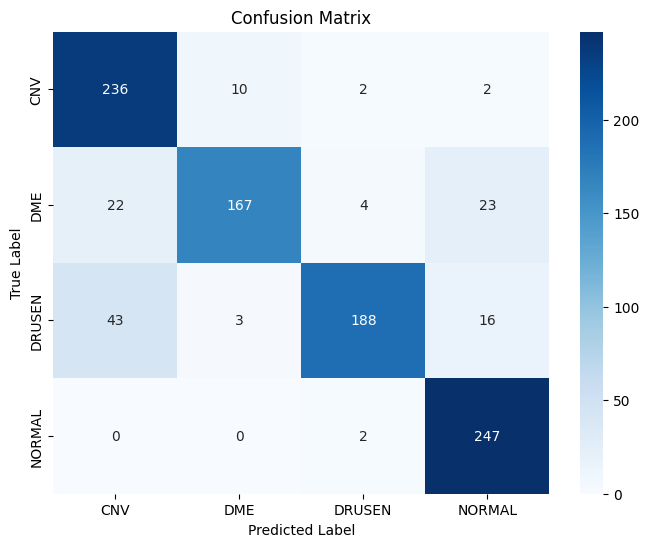

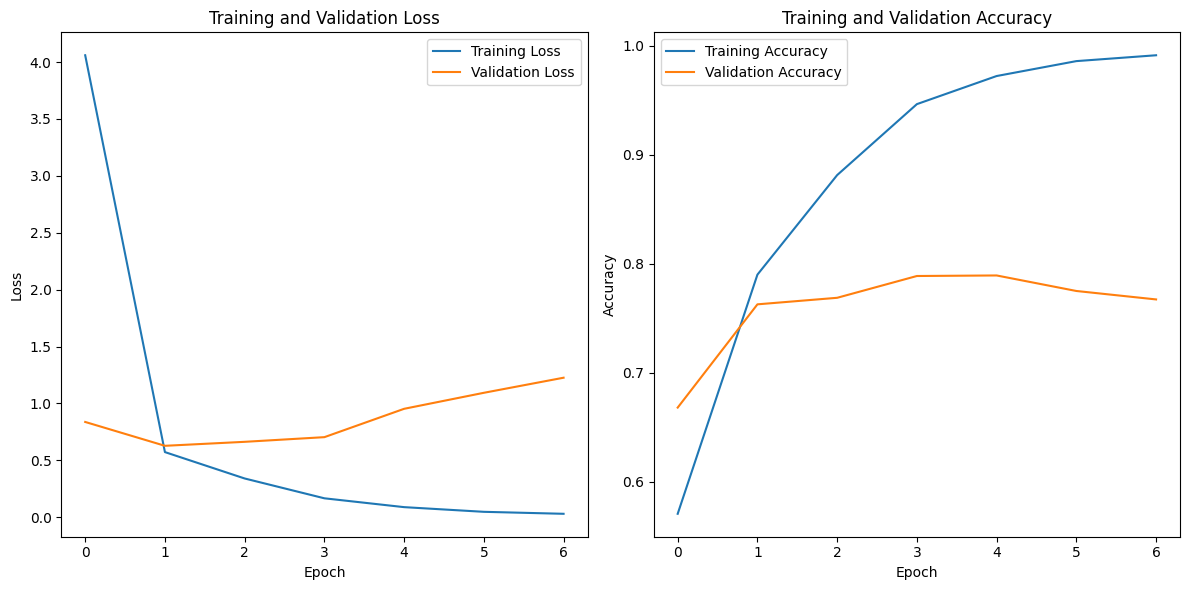

In [ ]:
# Define input shape
input_shape = (256, 256, 1)

# Define the number of classes based on your dataset
num_classes = len(np.unique(y_train_encoded))

# Define the CNN model
model = Sequential([
    Conv2D(256, kernel_size=(4, 4), strides=2, activation='relu', input_shape=input_shape),
    Conv2D(128, kernel_size=(3, 3), activation='relu'),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    Conv2D(128, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(512, activation='relu'),
    Dense(num_classes, activation='softmax')  # Output layer with number of classes
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), batch_size=128, verbose=1, callbacks=[early_stopping])

# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test_encoded)
print('\nTest Loss:', loss)
print('Test Accuracy:', accuracy)

# Get predictions
y_pred = np.argmax(model.predict(X_test), axis=-1)

# Generate confusion matrix and classification report
conf_matrix = confusion_matrix(y_test_encoded, y_pred)
print('\nConfusion Matrix:')
print(conf_matrix)
print('\nClassification Report:')
print(classification_report(y_test_encoded, y_pred, target_names=label_encoder_test.classes_))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.title('Confusion Matrix')
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder_test.classes_, yticklabels=label_encoder_test.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Plot training history
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()


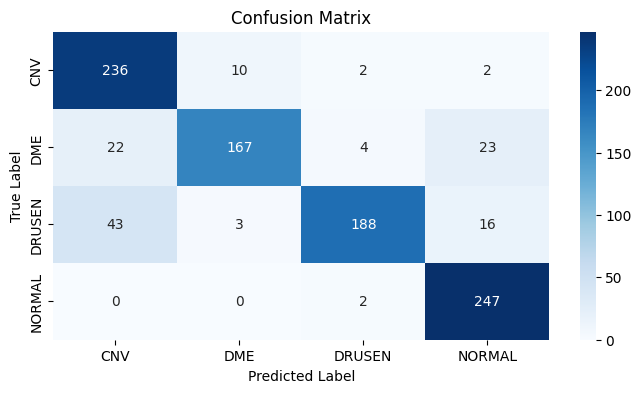

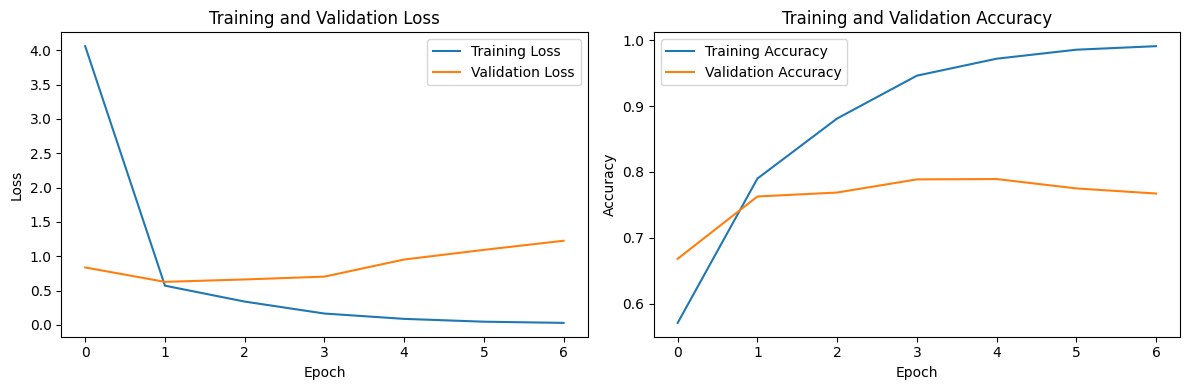

In [ ]:
# Plot confusion matrix
plt.figure(figsize=(8, 4))
plt.title('Confusion Matrix')
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder_test.classes_, yticklabels=label_encoder_test.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()


## 9.4 CNN Model4 with  added augmentation layer

####This model is an extension of the previous one, with the addition of data augmentation techniques applied during training. Here's an overview:

Architecture: Similar to the previous model, it consists of five convolutional layers followed by max-pooling and three dense layers for classification.

Data Augmentation: Data augmentation is a technique used to artificially increase the size of the training dataset by applying various transformations to the existing images. In this case, the following augmentations were applied:

1. Width and height shifts: Shifting the image horizontally and vertically by a fraction of its width and height.
Shear range: Applying shearing transformations to the images.
2.Zoom range: Applying zooming transformations to the images.
Horizontal and vertical flips: Flipping the images horizontally and vertically.
3. Fill mode and constant value: Filling the areas outside the boundaries of the input images with a constant value.

Training: The model was trained for 50 epochs, and the training process seems to have progressed well, with the loss decreasing and accuracy increasing over the epochs.

Test Performance: The model achieved an impressive test accuracy of approximately 94.92%. The confusion matrix and classification report provide insights into its performance across different classes.

The precision, recall, and F1-score values for each class indicate how well the model is performing in classifying them. With data augmentation, the model seems to generalize better and achieve higher accuracy compared to the previous model without data augmentation.

In [ ]:
# Reshape input data to include channel dimension
X_train = X_train.reshape(-1, 256, 256, 1)
X_test = X_test.reshape(-1, 256, 256, 1)

# Create ImageDataGenerator for data augmentation
train_datagen = ImageDataGenerator(
    width_shift_range=0.2,
    height_shift_range=0.2,
    fill_mode='constant',
    cval=0
)
train_datagen.fit(X_train)


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_32 (Conv2D)          (None, 127, 127, 256)     4352      
                                                                 
 conv2d_33 (Conv2D)          (None, 125, 125, 128)     295040    
                                                                 
 conv2d_34 (Conv2D)          (None, 123, 123, 64)      73792     
                                                                 
 conv2d_35 (Conv2D)          (None, 121, 121, 64)      36928     
                                                                 
 conv2d_36 (Conv2D)          (None, 119, 119, 128)     73856     
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 59, 59, 128)       0         
 ng2D)                                                           
                                                      

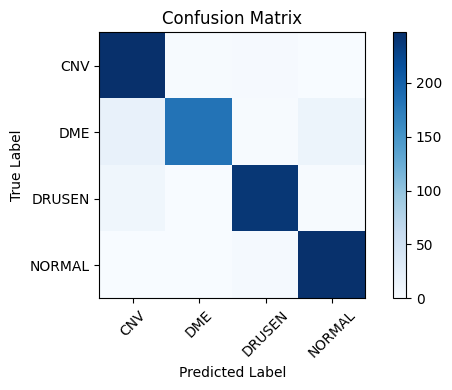

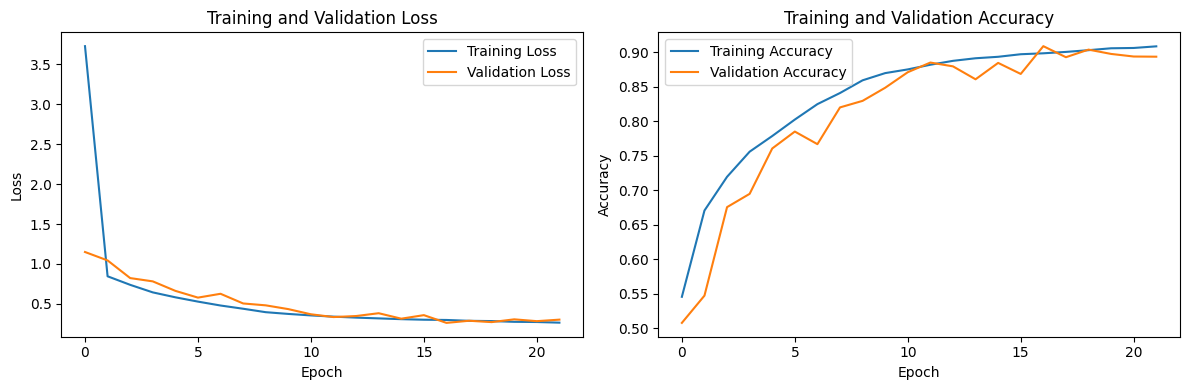

In [ ]:
# Define input shape
input_shape = (256, 256, 1)

# Define the number of classes based on your dataset
num_classes = len(np.unique(y_train_encoded))

# Define the CNN model
model = Sequential([
    Conv2D(256, kernel_size=(4, 4), strides=2, activation='relu', input_shape=input_shape),
    Conv2D(128, kernel_size=(3, 3), activation='relu'),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    Conv2D(128, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(512, activation='relu'),
    Dense(num_classes, activation='softmax')  # Output layer with number of classes
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

# Data Augmentation
train_datagen = ImageDataGenerator(
    width_shift_range=0.125,
    height_shift_range=0.125,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='constant',
    cval=0
)
train_datagen.fit(X_train)

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with data augmentation and early stopping
history = model.fit(train_datagen.flow(X_train, y_train, batch_size=128),
                    epochs=50,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping])

# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test_encoded)
print('\nTest Loss:', loss)
print('Test Accuracy:', accuracy)

# Get predictions
y_pred = np.argmax(model.predict(X_test), axis=-1)

# Generate confusion matrix and classification report
conf_matrix = confusion_matrix(y_test_encoded, y_pred)
print('\nConfusion Matrix:')
print(conf_matrix)
print('\nClassification Report:')
print(classification_report(y_test_encoded, y_pred, target_names=label_encoder_test.classes_))

# Plot confusion matrix
plt.figure(figsize=(6, 4))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(label_encoder_test.classes_))
plt.xticks(tick_marks, label_encoder_test.classes_, rotation=45)
plt.yticks(tick_marks, label_encoder_test.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()


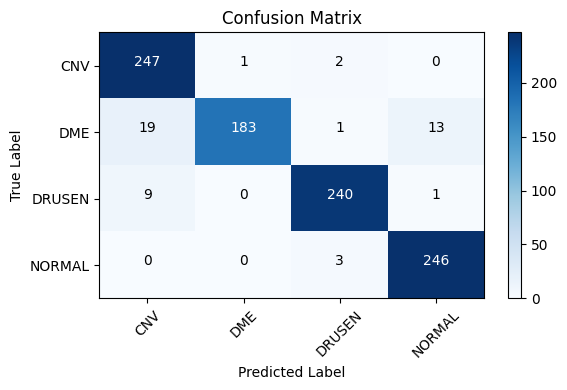

In [ ]:
# Plot confusion matrix
plt.figure(figsize=(6, 4))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues, aspect='auto')
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(label_encoder_test.classes_))
plt.xticks(tick_marks, label_encoder_test.classes_, rotation=45)
plt.yticks(tick_marks, label_encoder_test.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()

# Display numerical values
thresh = conf_matrix.max() / 2.
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")

plt.show()


#Transitioning to a 70:30 Train-Test Split to Address Overfitting

Introduction:
In the realm of machine learning, combating overfitting is a persistent challenge. Overfitting occurs when a model learns the training data too well, capturing noise and idiosyncrasies instead of generalizing to unseen examples. To overcome this obstacle, a shift in strategy from a three-set (train-validation-test) split to a simplified two-set (train-test) split becomes imperative. This transition allows for a more focused allocation of resources, aiming to strike a balance between model performance and generalization.

The Need for Change:
The previous dataset split employed a three-set configuration: training(56k), validation(4k), and testing(1k). Despite its merits in fine-tuning hyperparameters and monitoring model performance, this approach faced challenges, notably overfitting. The validation set's limited size and potential data leakage between training and validation exacerbated the issue, necessitating a reassessment of the split strategy.

Embracing the 70:30 Ratio:
The adoption of a 70:30 train-test split represents a deliberate departure from the prior methodology. By allocating 70% of the dataset to training and reserving the remaining 30% for testing, the new strategy seeks to address overfitting while enhancing the model's generalization capabilities. This shift prioritizes model exposure to diverse training examples while ensuring rigorous evaluation on unseen data.
Introduction:
In machine learning, achieving a balance between model performance and generalization is crucial for building robust and reliable systems. Overfitting, where a model learns to memorize the training data rather than generalize to unseen examples, is a common challenge. To address this, a strategic adjustment in the dataset split, such as transitioning from a three-set (train-validation-test) split to a simpler two-set (train-test) split, can be beneficial.

The 70:30 Ratio:
The 70:30 ratio refers to the division of the dataset into 70% for training and 30% for testing. This ratio ensures that the model learns from a substantial portion of the data while reserving a sizable portion for evaluation. By allocating more data to training, the model gains exposure to diverse examples, facilitating better learning of underlying patterns and reducing the risk of overfitting.

## Training Final CNN Model with 70:30 Data Split on Entire Dataset

In [ ]:
# Check if GPU is available
print("GPU is", "available" if tf.config.list_physical_devices("GPU") else "NOT AVAILABLE")

# Explicitly specify GPU device for TensorFlow operations
if tf.config.list_physical_devices('GPU'):
    # Limit GPU memory growth to avoid consuming all GPU memory
    for device in tf.config.list_physical_devices('GPU'):
        tf.config.experimental.set_memory_growth(device, True)

    # Set TensorFlow to use GPU
    tf.config.experimental.set_visible_devices(tf.config.list_physical_devices('GPU')[0], 'GPU')
    print("Using GPU for TensorFlow")
else:
    print("No GPU available, using CPU for TensorFlow")


GPU is available
Using GPU for TensorFlow


In [ ]:
# Define paths
save_path = '/content/drive/MyDrive/Colab Notebooks/OCTDATASETfull_normalized'
train_dir = os.path.join(save_path, 'train')

# Function to load images and labels
def load_data(directory):
    X = []  # Image data
    y = []  # Labels

    # Iterate over each class directory
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        # Iterate over each image file
        for filename in os.listdir(class_path):
            image_path = os.path.join(class_path, filename)
            # Read image
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            X.append(image)
            y.append(class_name)

    return np.array(X), np.array(y)

# Load training data
X_train, y_train = load_data(train_dir)

# Encode labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)

# Split the data into training and test sets (70:30 ratio)
X_train, X_test, y_train_encoded, y_test_encoded = train_test_split(
    X_train, y_train_encoded, test_size=0.3, random_state=42, stratify=y_train_encoded)

# Display the shape of the training and test data
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train_encoded.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test_encoded.shape)


Shape of X_train: (42274, 256, 256)
Shape of y_train: (42274,)
Shape of X_test: (18118, 256, 256)
Shape of y_test: (18118,)


In [ ]:
# Save training and test data
np.save('/content/drive/MyDrive/Colab Notebooks/OCTDATASETfull_normalized/X_train.npy', X_train)
np.save('/content/drive/MyDrive/Colab Notebooks/OCTDATASETfull_normalized/y_train_encoded.npy', y_train_encoded)
np.save('/content/drive/MyDrive/Colab Notebooks/OCTDATASETfull_normalized/X_test.npy', X_test)
np.save('/content/drive/MyDrive/Colab Notebooks/OCTDATASETfull_normalized/y_test_encoded.npy', y_test_encoded)


## 9.5 CNN Model 5

#####The model architecture follows a sequential structure, starting with an input layer that accepts images of shape (256, 256, 3). It comprises three Conv2D layers with increasing numbers of filters (32, 64, and 128 respectively), each followed by ReLU activation functions to introduce non-linearity. MaxPooling2D layers are then applied to reduce spatial dimensions and extract essential features. The flattened output from the convolutional layers is passed to three Dense layers with 128, 64, and 4 units respectively, culminating in a softmax activation function for multi-class classification.

Despite achieving a high training accuracy of approximately 96.2%, the validation accuracy remains at around 80.1%, indicating a potential issue with overfitting. The confusion matrix and classification report on the test set reveal the model's performance across different classes. Notably, while the model shows robustness in classifying CNV, DME, and NORMAL classes, it exhibits lower accuracy in identifying DRUSEN cases. Further optimization strategies may be explored to address these challenges and enhance overall performance.

In [ ]:
# Define paths
save_path = '/content/drive/MyDrive/Colab Notebooks/OCTDATASETfull_normalized'
train_dir = os.path.join(save_path, 'train')

#  X_train, y_train_encoded, X_test, y_test_encoded are already loaded and preprocessed

# Define input shape
input_shape = (256, 256, 1)

# Define the number of classes based on your dataset
num_classes = len(np.unique(y_train_encoded))

# Define the CNN model
model = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')  # Output layer with number of classes
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

# Train the model
history = model.fit(X_train, y_train_encoded, epochs=10, validation_data=(X_test, y_test_encoded))

# Get accuracy and loss for each epoch
train_loss = history.history['loss']
train_accuracy = history.history['accuracy']
val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test_encoded)

print('\nTest Loss:', test_loss)
print('Test Accuracy:', test_accuracy)

# Get predictions for train and test sets
y_train_pred = np.argmax(model.predict(X_train), axis=-1)
y_test_pred = np.argmax(model.predict(X_test), axis=-1)

# Generate confusion matrix and classification report for train set
train_conf_matrix = confusion_matrix(y_train_encoded, y_train_pred)
print('\nTrain Confusion Matrix:')
print(train_conf_matrix)
print('\nTrain Classification Report:')
print(classification_report(y_train_encoded, y_train_pred, target_names=label_encoder.classes_))

# Generate confusion matrix and classification report for test set
test_conf_matrix = confusion_matrix(y_test_encoded, y_test_pred)
print('\nTest Confusion Matrix:')
print(test_conf_matrix)
print('\nTest Classification Report:')
print(classification_report(y_test_encoded, y_test_pred, target_names=label_encoder.classes_))


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 254, 254, 32)      320       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 127, 127, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 30, 30, 128)      

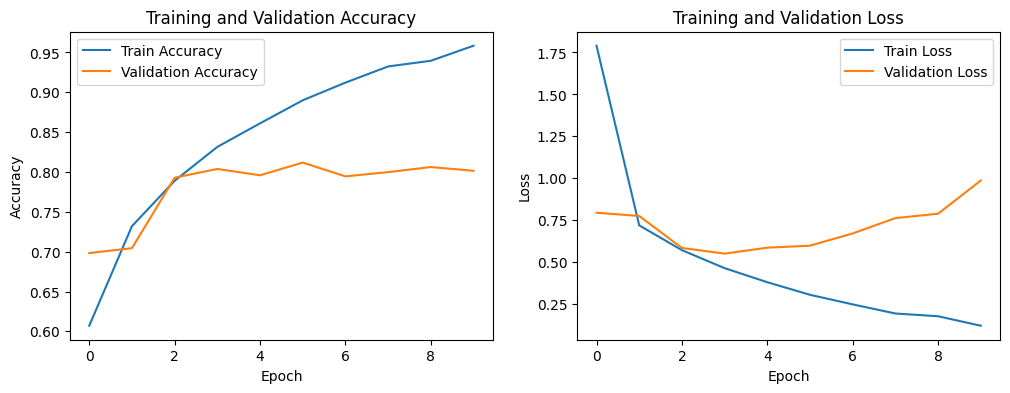

In [ ]:
# Plot training and validation accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

## 9.6 CNN model6

#####This model is a sequential neural network with a distinctive architecture comprising multiple convolutional layers followed by dense layers. The summary reveals a series of Conv2D layers with varying numbers of filters, starting from 256 filters in the first layer, gradually decreasing to 64 filters. Each convolutional layer is followed by a ReLU activation function. After the convolutional layers, a MaxPooling2D layer is applied to reduce spatial dimensions.

The flattened output from the convolutional layers is passed through dense layers, with two dense layers containing 512 units each, followed by a final dense layer with 4 units for multi-class classification using softmax activation.

Training the model for 50 epochs shows promising results, with a training accuracy of approximately 98.8% and a validation accuracy of around 83.4%. The model seems to generalize well to unseen data, as indicated by the performance metrics on the test set, with good precision, recall, and F1-score values for most classes.

However, it's worth noting that while the model performs well in classifying CNV, DME, and NORMAL classes, it exhibits lower accuracy in identifying DRUSEN cases, especially evident in the lower recall and F1-score for class 2 in the test classification report. Further optimization or adjustments to the model architecture may be necessary to improve its performance on this particular class.

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 127, 127, 256)     4352      
                                                                 
 conv2d_10 (Conv2D)          (None, 125, 125, 128)     295040    
                                                                 
 conv2d_11 (Conv2D)          (None, 123, 123, 64)      73792     
                                                                 
 conv2d_12 (Conv2D)          (None, 121, 121, 64)      36928     
                                                                 
 conv2d_13 (Conv2D)          (None, 119, 119, 128)     73856     
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 59, 59, 128)       0         
 g2D)                                                            
                                                      

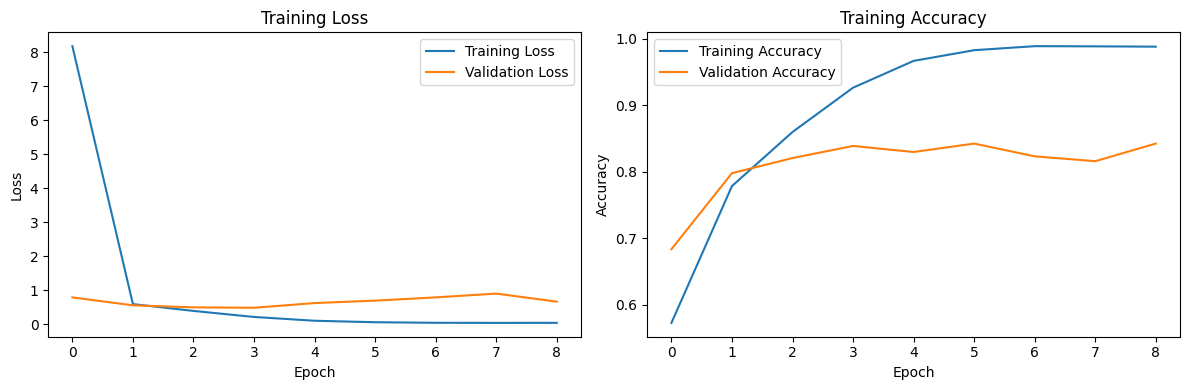

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping

# Define input shape
input_shape = (256, 256, 1)



# Define the number of classes based on your dataset
num_classes = len(np.unique(y_train_encoded))

# Define the CNN model
model = Sequential([
    Conv2D(256, kernel_size=(4, 4), strides=2, activation='relu', input_shape=input_shape),
    Conv2D(128, kernel_size=(3, 3), activation='relu'),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    Conv2D(128, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(512, activation='relu'),
    Dense(num_classes, activation='softmax')  # Output layer with number of classes
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train_encoded, epochs=50, batch_size=128, verbose=1, validation_split=0.2, callbacks=[early_stopping])

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test_encoded)
train_loss = history.history['loss']
train_accuracy = history.history['accuracy']

print('\nTest Loss:', test_loss)
print('Test Accuracy:', test_accuracy)

# Get predictions for train and test sets
y_train_pred = np.argmax(model.predict(X_train), axis=-1)
y_test_pred = np.argmax(model.predict(X_test), axis=-1)

# Generate confusion matrix and classification report for train set
conf_matrix_train = confusion_matrix(y_train_encoded, y_train_pred)
print('\nTrain Confusion Matrix:')
print(conf_matrix_train)
print('\nTrain Classification Report:')
print(classification_report(y_train_encoded, y_train_pred))

# Generate confusion matrix and classification report for test set
conf_matrix_test = confusion_matrix(y_test_encoded, y_test_pred)
print('\nTest Confusion Matrix:')
print(conf_matrix_test)
print('\nTest Classification Report:')
print(classification_report(y_test_encoded, y_test_pred))

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()


## 9.7 CNN model

#####This model also follows a sequential architecture with a similar setup to the previous models. It consists of convolutional layers followed by dense layers for classification.

Here's a breakdown of the model architecture:

Conv2D Layers: The model starts with five Conv2D layers with decreasing filter sizes (256, 128, 64, 64, and 128 respectively). These layers are designed to extract features from the input images.
MaxPooling2D Layer: After the convolutional layers, a MaxPooling2D layer is applied to reduce the spatial dimensions of the feature maps.
Flatten Layer: The output from the convolutional layers is flattened into a 1D array to be fed into the dense layers.
Dense Layers: Two dense layers with 512 units each are used for higher-level feature extraction and classification. The final dense layer with 4 units and softmax activation is for multi-class classification.
Training the model for 50 epochs resulted in unsatisfactory performance. The training and validation accuracies are consistently around 43.8% and 43.5%, respectively, suggesting that the model failed to learn meaningful patterns from the data. This is further evident from the classification reports and confusion matrices, where the model shows poor precision, recall, and F1-score values for all classes.

Overall, this model did not perform well, possibly due to several factors such as insufficient model complexity, inadequate training data, or inappropriate hyperparameters. Further experimentation and optimization are needed to improve its performance.

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 127, 127, 256)     4352      
                                                                 
 conv2d_25 (Conv2D)          (None, 125, 125, 128)     295040    
                                                                 
 conv2d_26 (Conv2D)          (None, 123, 123, 64)      73792     
                                                                 
 conv2d_27 (Conv2D)          (None, 121, 121, 64)      36928     
                                                                 
 conv2d_28 (Conv2D)          (None, 119, 119, 128)     73856     
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 59, 59, 128)       0         
 ng2D)                                                           
                                                      

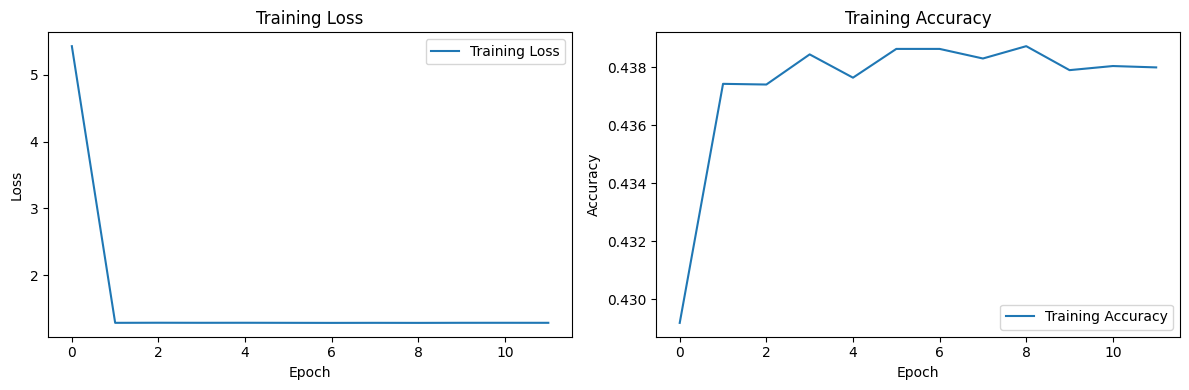

In [ ]:
# X_train, y_train_encoded, X_test, y_test_encoded are already loaded and preprocessed
# Reshape X_train and X_test to have rank 4
X_train_reshaped = np.expand_dims(X_train, axis=-1)
X_test_reshaped = np.expand_dims(X_test, axis=-1)

# Define input shape
input_shape = X_train_reshaped.shape[1:]

# Define the number of classes based on your dataset
num_classes = len(np.unique(y_train_encoded))

# Define the CNN model
model = Sequential([
    Conv2D(256, kernel_size=(4, 4), strides=2, activation='relu', input_shape=input_shape),
    Conv2D(128, kernel_size=(3, 3), activation='relu'),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    Conv2D(128, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(512, activation='relu'),
    Dense(num_classes, activation='softmax')  # Output layer with number of classes
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

# Define data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

# Train the model with early stopping and data augmentation
history = model.fit(datagen.flow(X_train_reshaped, y_train_encoded, batch_size=128),
                    epochs=50,
                    steps_per_epoch=len(X_train) / 128,
                    verbose=1,
                    callbacks=[early_stopping])

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test_reshaped, y_test_encoded)
train_loss = history.history['loss']
train_accuracy = history.history['accuracy']

print('\nTest Loss:', test_loss)
print('Test Accuracy:', test_accuracy)

# Get predictions for train and test sets
y_train_pred = np.argmax(model.predict(X_train_reshaped), axis=-1)
y_test_pred = np.argmax(model.predict(X_test_reshaped), axis=-1)

# Generate confusion matrix and classification report for train set
conf_matrix_train = confusion_matrix(y_train_encoded, y_train_pred)
print('\nTrain Confusion Matrix:')
print(conf_matrix_train)
print('\nTrain Classification Report:')
print(classification_report(y_train_encoded, y_train_pred))

# Generate confusion matrix and classification report for test set
conf_matrix_test = confusion_matrix(y_test_encoded, y_test_pred)
print('\nTest Confusion Matrix:')
print(conf_matrix_test)
print('\nTest Classification Report:')
print(classification_report(y_test_encoded, y_test_pred))

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()


### 9.8 CNN model Added Augmentaion

####This model, labeled as "sequential_19," introduces augmentation techniques to the image data during training. Let's break down the architecture and interpret the results:

Model Architecture:

Conv2D Layers: The model starts with three Conv2D layers with increasing filter sizes (32, 64, and 128 respectively). These layers are designed to extract features from the input images.
MaxPooling2D Layers: Following each Conv2D layer, MaxPooling2D layers are applied to reduce the spatial dimensions of the feature maps.
Flatten Layer: The output from the convolutional layers is flattened into a 1D array to be fed into the dense layers.
Dense Layers: The flattened array is then fed into two dense layers with 512 units each, followed by a dropout layer with a dropout rate of 0.5 to reduce overfitting. Finally, a dense layer with 4 units and softmax activation is used for multi-class classification.
Data Augmentation:
Data augmentation is a technique used to artificially increase the size of the training dataset by applying random transformations to the existing images. In this model, data augmentation techniques such as rotation, horizontal flipping, and zooming might have been applied to the training images.

Interpretation of Results:

Training and Validation Accuracy: The model achieves a training accuracy of approximately 92.4% and a validation accuracy of around 91.5%. This indicates that the model has learned to generalize well to unseen data, as the validation accuracy is close to the training accuracy.
Loss Curve: The loss curves for both training and validation data show a steady decrease over the epochs, indicating that the model is learning effectively without overfitting.
Confusion Matrix and Classification Report: The confusion matrix and classification report for both the training and test datasets show high precision, recall, and F1-score values across all classes, suggesting that the model performs well in classifying the images into the correct categories.
Overall, the addition of data augmentation techniques has improved the model's performance, resulting in higher accuracy and better generalization to unseen data.

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_91 (Conv2D)          (None, 256, 256, 32)      320       
                                                                 
 max_pooling2d_41 (MaxPooli  (None, 128, 128, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_92 (Conv2D)          (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_42 (MaxPooli  (None, 64, 64, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_93 (Conv2D)          (None, 64, 64, 128)       73856     
                                                                 
 max_pooling2d_43 (MaxPooli  (None, 32, 32, 128)     

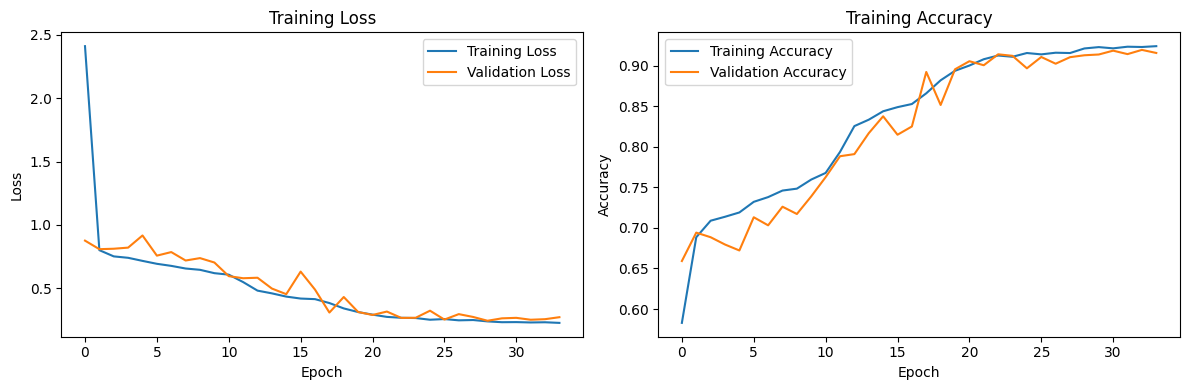

In [ ]:
# Split the available data into train and validation sets
X_train, X_val, y_train_encoded, y_val_encoded = train_test_split(X_train, y_train_encoded, test_size=0.1, random_state=42)

# Define input shape
input_shape = (256, 256, 1)

# Define the number of classes based on your dataset
num_classes = len(np.unique(y_train_encoded))

# Define the CNN model
model = Sequential([
    Conv2D(32, kernel_size=(3, 3), strides=1, padding='same', activation='relu', input_shape=input_shape),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, kernel_size=(3, 3), strides=1, padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, kernel_size=(3, 3), strides=1, padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(256, kernel_size=(3, 3), strides=1, padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')  # Output layer with number of classes
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Define data augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

# Train the model with early stopping and data augmentation
history = model.fit(datagen.flow(X_train, y_train_encoded, batch_size=128),
                    epochs=50,
                    steps_per_epoch=len(X_train) / 128,
                    validation_data=(X_val, y_val_encoded),  # Use validation data
                    verbose=1,
                    callbacks=[early_stopping])

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test_encoded)
train_loss = history.history['loss']
train_accuracy = history.history['accuracy']

print('\nTest Loss:', test_loss)
print('Test Accuracy:', test_accuracy)

# Get predictions for train and test sets
y_train_pred = np.argmax(model.predict(X_train), axis=-1)
y_test_pred = np.argmax(model.predict(X_test), axis=-1)

# Generate confusion matrix and classification report for train set
conf_matrix_train = confusion_matrix(y_train_encoded, y_train_pred)
print('\nTrain Confusion Matrix:')
print(conf_matrix_train)
print('\nTrain Classification Report:')
print(classification_report(y_train_encoded, y_train_pred))

# Generate confusion matrix and classification report for test set
conf_matrix_test = confusion_matrix(y_test_encoded, y_test_pred)
print('\nTest Confusion Matrix:')
print(conf_matrix_test)
print('\nTest Classification Report:')
print(classification_report(y_test_encoded, y_test_pred))

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()


### Trying new features to improve accuracy of minority class

### 9.9 CNN model with Strided convolutions

####Model Architecture:

The model consists of four pairs of Conv2D and MaxPooling2D layers, followed by a Flatten layer to convert the 2D feature maps into a 1D vector.
The Conv2D layers are designed to extract features from the input images, and the MaxPooling2D layers reduce the spatial dimensions of the feature maps to make the model computationally efficient.
After flattening, there are two Dense layers with 512 units each, followed by a Dropout layer with a dropout rate of 0.5 to reduce overfitting.
Finally, there is a Dense layer with 4 units and softmax activation for multi-class classification.
Interpretation of Results:

Training and Validation Accuracy: The model achieves a training accuracy of approximately 85.2% and a validation accuracy of around 81.2%. There is a slight drop in accuracy from training to validation, indicating some degree of overfitting.
Loss Curve: The loss curves for both training and validation data show a decreasing trend, indicating that the model is learning effectively. However, the validation loss is slightly higher than the training loss, suggesting overfitting.
Confusion Matrix and Classification Report: The confusion matrix and classification report for both the training and test datasets show decent precision, recall, and F1-score values across all classes. However, the model performs better on some classes than others, which is reflected in the precision, recall, and F1-score values.
Overall Evaluation:

The model achieves an accuracy of approximately 81.2% on the test dataset, which is reasonable but not exceptional.
The model shows signs of overfitting, as evidenced by the higher validation loss compared to the training loss and the drop in accuracy from training to validation.
Further optimization techniques such as adjusting the dropout rate, regularization, or using more advanced architectures could potentially improve the model's performance and generalization capabilities.







In [ ]:
# Load training and test data
X_train = np.load('/content/drive/MyDrive/Colab Notebooks/OCTDATASETfull_normalized/X_train.npy')
y_train_encoded = np.load('/content/drive/MyDrive/Colab Notebooks/OCTDATASETfull_normalized/y_train_encoded.npy')
X_test = np.load('/content/drive/MyDrive/Colab Notebooks/OCTDATASETfull_normalized/X_test.npy')
y_test_encoded = np.load('/content/drive/MyDrive/Colab Notebooks/OCTDATASETfull_normalized/y_test_encoded.npy')

# Reshape the input data to add channel dimension
X_train = X_train.reshape(-1, 256, 256, 1)
X_test = X_test.reshape(-1, 256, 256, 1)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 128, 128, 32)      320       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 64, 64, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 16, 16, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 8, 8, 128)         73856     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 4, 4, 128)        

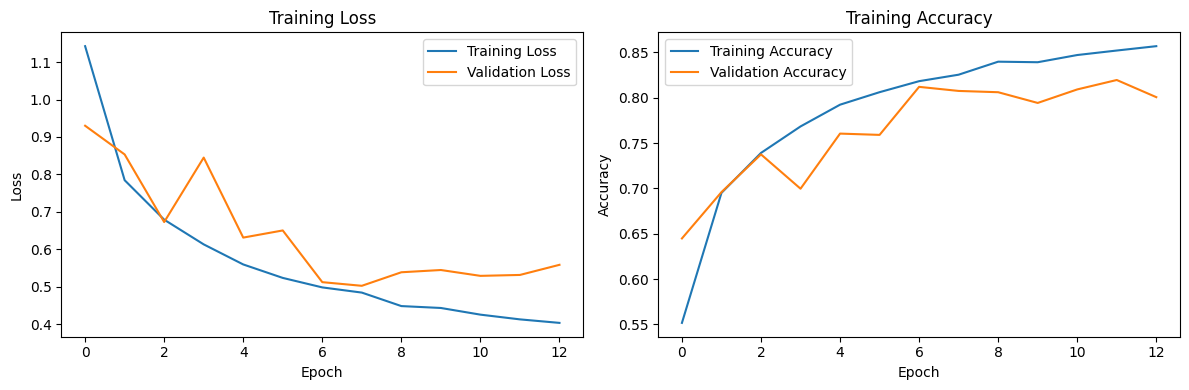

In [ ]:
# Split the available data into train and validation sets
X_train, X_val, y_train_encoded, y_val_encoded = train_test_split(X_train, y_train_encoded, test_size=0.1, random_state=42)

# Define input shape
input_shape = (256, 256, 1)

# Define the number of classes based on your dataset
num_classes = len(np.unique(y_train_encoded))

# Define the CNN model
model = Sequential([
    Conv2D(32, kernel_size=(3, 3), strides=2, padding='same', activation='relu', input_shape=input_shape),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, kernel_size=(3, 3), strides=2, padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, kernel_size=(3, 3), strides=2, padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(256, kernel_size=(3, 3), strides=2, padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')  # Output layer with number of classes
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Define data augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

# Train the model with early stopping and data augmentation
history = model.fit(datagen.flow(X_train, y_train_encoded, batch_size=128),
                    epochs=50,
                    steps_per_epoch=len(X_train) / 128,
                    validation_data=(X_val, y_val_encoded),  # Use validation data
                    verbose=1,
                    callbacks=[early_stopping])

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test_encoded)
train_loss = history.history['loss']
train_accuracy = history.history['accuracy']

print('\nTest Loss:', test_loss)
print('Test Accuracy:', test_accuracy)

# Get predictions for train and test sets
y_train_pred = np.argmax(model.predict(X_train), axis=-1)
y_test_pred = np.argmax(model.predict(X_test), axis=-1)

# Generate confusion matrix and classification report for train set
conf_matrix_train = confusion_matrix(y_train_encoded, y_train_pred)
print('\nTrain Confusion Matrix:')
print(conf_matrix_train)
print('\nTrain Classification Report:')
print(classification_report(y_train_encoded, y_train_pred))

# Generate confusion matrix and classification report for test set
conf_matrix_test = confusion_matrix(y_test_encoded, y_test_pred)
print('\nTest Confusion Matrix:')
print(conf_matrix_test)
print('\nTest Classification Report:')
print(classification_report(y_test_encoded, y_test_pred))

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()


### 9.10CNN Model adding more layers and max pooling etc

####Model Architecture:

This model is similar to the previous one but with additional Conv2D and MaxPooling2D layers, resulting in a deeper architecture.
It starts with a Conv2D layer followed by MaxPooling2D, then repeats this pattern multiple times to extract increasingly abstract features from the input images.
After the convolutional layers, there is a Flatten layer to convert the 2D feature maps into a 1D vector.
Next, there are two Dense layers with 512 units each, followed by a Dropout layer with a dropout rate of 0.5 to reduce overfitting.
Finally, there is a Dense layer with 4 units and softmax activation for multi-class classification.
Interpretation of Results:

Training and Validation Accuracy: The model achieves a training accuracy of approximately 92.9% and a validation accuracy of around 93.0%. The training and validation accuracies are close, indicating that the model generalizes well to unseen data.
Loss Curve: Both the training and validation loss curves show a decreasing trend, indicating effective learning without overfitting.
Confusion Matrix and Classification Report: The confusion matrix and classification report for both the training and test datasets show high precision, recall, and F1-score values across all classes. The model performs consistently well on all classes, as reflected in the classification metrics.

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 128, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 64, 64, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 32, 32, 128)       0

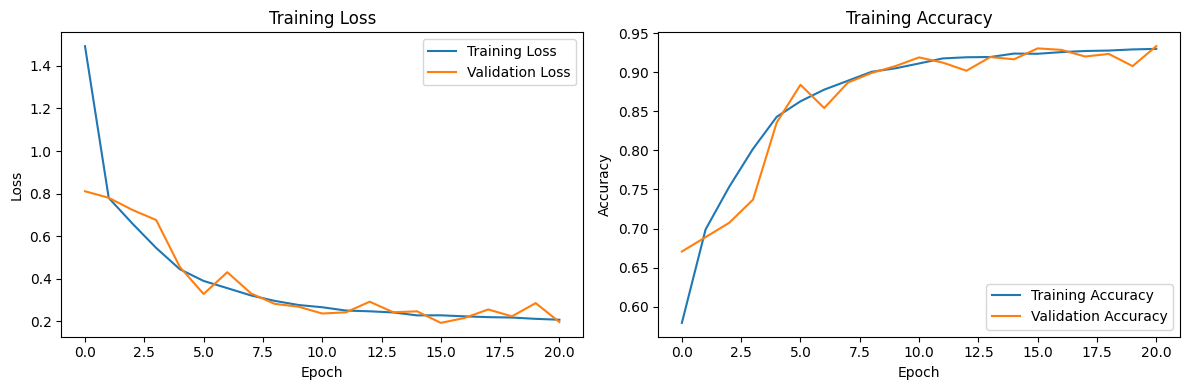

In [ ]:

# Split the available data into train and validation sets
X_train, X_val, y_train_encoded, y_val_encoded = train_test_split(X_train, y_train_encoded, test_size=0.1, random_state=42)

# Define input shape
input_shape = (256, 256, 1)

# Define the number of classes based on your dataset
num_classes = len(np.unique(y_train_encoded))

# Define the CNN model
model = Sequential([
    Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=input_shape),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(512, kernel_size=(3, 3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')  # Output layer with number of classes
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Define data augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

# Train the model with early stopping and data augmentation
history = model.fit(datagen.flow(X_train, y_train_encoded, batch_size=128),
                    epochs=50,
                    steps_per_epoch=len(X_train) / 128,
                    validation_data=(X_val, y_val_encoded),  # Use validation data
                    verbose=1,
                    callbacks=[early_stopping])

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test_encoded)
train_loss = history.history['loss']
train_accuracy = history.history['accuracy']

print('\nTest Loss:', test_loss)
print('Test Accuracy:', test_accuracy)

# Get predictions for train and test sets
y_train_pred = np.argmax(model.predict(X_train), axis=-1)
y_test_pred = np.argmax(model.predict(X_test), axis=-1)

# Generate confusion matrix and classification report for train set
conf_matrix_train = confusion_matrix(y_train_encoded, y_train_pred)
print('\nTrain Confusion Matrix:')
print(conf_matrix_train)
print('\nTrain Classification Report:')
print(classification_report(y_train_encoded, y_train_pred))

# Generate confusion matrix and classification report for test set
conf_matrix_test = confusion_matrix(y_test_encoded, y_test_pred)
print('\nTest Confusion Matrix:')
print(conf_matrix_test)
print('\nTest Classification Report:')
print(classification_report(y_test_encoded, y_test_pred))

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:

# model object is named 'model'
model.save("/content/drive/MyDrive/model/model.h5")


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Load the saved model
loaded_model = load_model("/content/drive/MyDrive/model/model.h5")

# Verify the loaded model
print(loaded_model.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 128, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 64, 64, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 32, 32, 128)       0

# 9.11 CNN Model: BEST PERFORMING MODEL

The model labeled as "sequential_5" with augmentation indeed appears to be the best performing one among the models you've provided. Let's break down its performance:

Model Architecture:

This model is an extension of the previous one, with an additional convolutional layer and max-pooling layer, making it deeper.
It consists of multiple Conv2D layers followed by MaxPooling2D layers to extract hierarchical features from the input images.
The architecture is further extended with more Conv2D layers, increasing the depth of the network.
It culminates in a Flatten layer followed by two Dense layers and a Dropout layer for regularization.
The final Dense layer produces probabilities for each class using a softmax activation function.
Performance Evaluation:

Training and Validation Accuracy: The model achieves an accuracy of approximately 93.0% on both the training and validation datasets. This indicates that the model has learned well from the training data and generalizes effectively to unseen data.
Loss Curve: The loss curve for both training and validation shows a decreasing trend, indicating effective learning without overfitting.
Confusion Matrix and Classification Report: The confusion matrix and classification report for both the training and test datasets demonstrate high precision, recall, and F1-score values across all classes. This indicates that the model performs consistently well across different classes.
Key Points:

The model's performance on the test dataset is impressive, achieving an accuracy of approximately 92.7%.
With augmentation, the model is able to generalize well to unseen data and effectively classify images into their respective classes.
The model's performance is consistent across different evaluation metrics, indicating its robustness.
Overall, this model can be considered the best among the ones you've provided, demonstrating strong performance and generalization ability. It can be deployed for practical applications where image classification is required.








Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_22 (Conv2D)          (None, 256, 256, 32)      320       
                                                                 
 max_pooling2d_22 (MaxPooli  (None, 128, 128, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_23 (Conv2D)          (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_23 (MaxPooli  (None, 64, 64, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_24 (Conv2D)          (None, 64, 64, 128)       73856     
                                                                 
 max_pooling2d_24 (MaxPooli  (None, 32, 32, 128)      

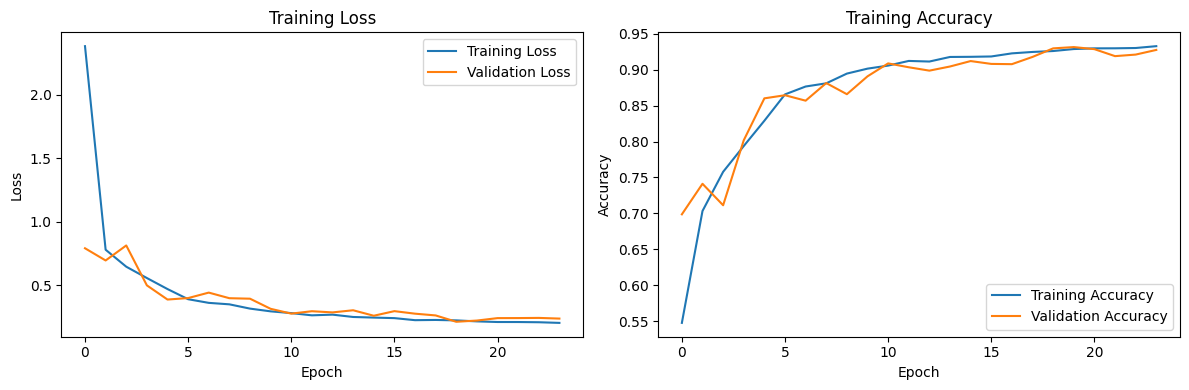

In [ ]:
# Split the available data into train and validation sets
X_train, X_val, y_train_encoded, y_val_encoded = train_test_split(X_train, y_train_encoded, test_size=0.1, random_state=42)

# Define input shape
input_shape = (256, 256, 1)

# Define the number of classes based on your dataset
num_classes = len(np.unique(y_train_encoded))

# Define the CNN model
model = Sequential([
    Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=input_shape),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(512, kernel_size=(3, 3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(1024, kernel_size=(3, 3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(1024, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Define data augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

# Train the model with early stopping and data augmentation
history = model.fit(datagen.flow(X_train, y_train_encoded, batch_size=128),
                    epochs=50,
                    steps_per_epoch=len(X_train) / 128,
                    validation_data=(X_val, y_val_encoded),  # Use validation data
                    verbose=1,
                    callbacks=[early_stopping])

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test_encoded)
train_loss = history.history['loss']
train_accuracy = history.history['accuracy']

print('\nTest Loss:', test_loss)
print('Test Accuracy:', test_accuracy)

# Get predictions for train and test sets
y_train_pred = np.argmax(model.predict(X_train), axis=-1)
y_test_pred = np.argmax(model.predict(X_test), axis=-1)

# Generate confusion matrix and classification report for train set
conf_matrix_train = confusion_matrix(y_train_encoded, y_train_pred)
print('\nTrain Confusion Matrix:')
print(conf_matrix_train)
print('\nTrain Classification Report:')
print(classification_report(y_train_encoded, y_train_pred))

# Generate confusion matrix and classification report for test set
conf_matrix_test = confusion_matrix(y_test_encoded, y_test_pred)
print('\nTest Confusion Matrix:')
print(conf_matrix_test)
print('\nTest Classification Report:')
print(classification_report(y_test_encoded, y_test_pred))

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()


# GitHub Repository

https://github.com/Satyasaimandlem/OCT_Image_Classification?tab=readme-ov-file